In [1]:
# Libraries
import pandas as pd
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

In [2]:
# RQ: How does different types of vegetation affect the radiation balance of a site? 

In [3]:
###### DATA PREP ######

In [4]:
### VK MobRad short and tall grass ###

In [215]:
# Setting the folder with MObRad data, easiet to use later this way
folder_mobrad = "C:/Users/48512/Desktop/Climate Studies/Period 5 and 6/Field Training Soil-Vegetation-Atmosphere Interactions/VK/MobRAD/Data files"

In [217]:
# Making a df with all of the MobRad data
df_list = list()

for filename in os.listdir(folder_mobrad):
        if filename.endswith(".txt"):
            full_path = os.path.join(folder_mobrad, filename)
            df = pd.read_csv(full_path, skiprows = [1])
            df_list.append(df)

merged_df_mobrad = pd.concat(df_list)

In [219]:
#pd.set_option("display.max_rows", None) # Uncomment to see the whole df, but it takes a lot of memory to do it
pd.set_option("display.max_columns", None)
#merged_df_mobrad 

In [223]:
merged_df_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,datetime
0,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN,2025-06-17 11:33:40
1,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN,2025-06-17 11:33:41
2,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN,2025-06-17 11:33:42
3,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN,2025-06-17 11:33:43
4,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN,2025-06-17 11:33:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,834,NaN,NaN,NaN,NaN,169,1225,49,854.27,187.59,402.255526,496.404526,666.68,-94.149,572.531,0.219591,32.738513,13.883333,555.499421,NaN,NaN,NaN,NaN,2025-06-18 12:25:49
834,835,NaN,NaN,NaN,NaN,169,1225,50,855.61,187.72,402.035589,496.104589,667.89,-94.069,573.821,0.219399,32.692297,13.900000,555.499421,NaN,NaN,NaN,NaN,2025-06-18 12:25:50
835,836,NaN,NaN,NaN,NaN,169,1225,51,856.95,187.95,401.860526,495.773526,669.00,-93.913,575.087,0.219324,32.641260,13.916667,555.499421,NaN,NaN,NaN,NaN,2025-06-18 12:25:51
836,837,NaN,NaN,NaN,NaN,169,1225,52,857.44,188.08,402.035589,495.563589,669.36,-93.528,575.832,0.219351,32.608883,13.933333,555.499421,NaN,NaN,NaN,NaN,2025-06-18 12:25:52


In [221]:
# Adding a Date Time index for easier plotting later
YEAR = 2025

def create_datetime(row):
    doy = int(row['DOY'])
    hhmm = f"{int(row['HHMM']):04d}" 
    hour = int(hhmm[:2])
    minute = int(hhmm[2:])
    second = int(row['SS'])
    
    dt = datetime(YEAR, 1, 1) + timedelta(days=doy - 1, hours=hour, minutes=minute, seconds=second)
    return dt

merged_df_mobrad['datetime'] = merged_df_mobrad.apply(create_datetime, axis=1)

In [225]:
# I want to delete collumns where datetime is between 12 and 13:30
# That is when someone messed up the measoutrments
# Define start and end times
start_time = pd.to_datetime('12:00').time()
end_time = pd.to_datetime('13:30').time()

# Keep rows where the datetime's time is NOT between 12:00 and 13:30
merged_df_mobrad = merged_df_mobrad[~merged_df_mobrad['datetime'].dt.time.between(start_time, end_time)]

In [227]:
# Dropping albedo outliers  

merged_df_mobrad = merged_df_mobrad[merged_df_mobrad['albedo'] <= 0.5]

In [235]:
merged_df_mobrad_copy = merged_df_mobrad.copy()
merged_df_mobrad_copy.set_index('datetime', inplace=True)
merged_df_mobrad_copy

merged_df_mobrad_copy_15min_avg = merged_df_mobrad_copy.resample('15T').mean()
merged_df_mobrad_copy_15min_avg 

C:\Users\48512\AppData\Local\Temp\ipykernel_7216\889777588.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  merged_df_mobrad_copy_15min_avg = merged_df_mobrad_copy.resample('15T').mean()


,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,340.5,-20.450122,-1.699690,51.981701,5.621392,168.0,1138.823529,30.088235,861.383647,140.103735,365.458356,479.631305,721.279912,-114.172949,607.106963,0.163493,30.118421,5.658333,172.376344,-1.142353,61.411931,180.399766,NaN
2025-06-17 11:45:00,852.0,53.667600,37.223679,51.982027,5.622490,168.0,1147.376093,28.434402,865.133615,122.573085,365.269156,488.112351,742.560531,-122.843195,619.717335,0.141724,31.449346,14.183333,468.142279,0.321581,61.362498,184.428222,NaN
2025-06-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 09:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-18 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# folder_path = r'C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\df_save'
# os.makedirs(folder_path, exist_ok=True)

# shortgrass_mobrad.to_csv(os.path.join(folder_path, 'shortgrass_mobrad.csv'), index=False)
# tallgrass_mobrad.to_csv(os.path.join(folder_path, 'tallgrass_mobrad.csv'), index=False)

# EB_VK_shortgrass.to_csv(os.path.join(folder_path, 'EB_VK_shortgrass.csv'), index=False)
# EB_VK_tallgrass.to_csv(os.path.join(folder_path, 'EB_VK_tallgrass.csv'), index=False)

In [12]:
# Now I want to extract two separate dfs'. One for each vegetation type (tall vs. short grass)
# If lon ? 5*37'18.8'', then it is tall grass
# 5*37'18.8'' is 5.621889
# This also takes out the NaN location values

threshold_lon = 5.621889

# Filtering rows where lon >= threshold_lon
filtered_df = merged_df_mobrad [merged_df_mobrad ['lon'] >= threshold_lon]
tallgrass_mobrad = filtered_df.copy()

# Filterin rows where lon < threshold_lon
filtered_df = merged_df_mobrad [merged_df_mobrad ['lon'] < threshold_lon]
shortgrass_mobrad = filtered_df.copy()

# Setting datetime index
shortgrass_mobrad.set_index('datetime', inplace=True) 
tallgrass_mobrad.set_index('datetime', inplace=True) # set datetime as index

In [13]:
#plt.hist(merged_df_mobrad["lon"]) # Data check
# Most of the data is in the middle of the field so it looks correct

In [14]:
### VK Eddy Covariance shortgrass ###
### VK Eddy Covariance tallgrass ###

### this I need for Latent Heat flux (LvE) and sensible heat (H)

In [15]:
# Now I want to add to the merged_df the flux profile data
# I will do it based on a shared timestamp (datetime)
# First, I download the flux profile data. 
# The data for shortgrass is in the DATA_FTSVAI/VEENKAMPEN/2025/DATA_RAW/meteo/MainStation/Data-EC
# The data for longgrass is in the DATA_FTSVAI/VEENKAMPEN/2025/DATA_EDITED/Meteo/EC_Fixed_Grass_And_Swamp
# First I do it for VK for 17.06 and 18.06 (days when we were walking around VK with the MObRad)

# # shortgrass
flux_prof_VK_shortgrass_0617 = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK\VK_flux20250617(in).csv", skiprows=[1], encoding='latin1',sep=',')
flux_prof_VK_shortgrass_0618 = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK\VK_flux20250618(in).csv", skiprows=[1], encoding='latin1', sep=',')

# tallgrass
flux_prof_VK_tallgrass = pd.read_excel(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK\VK_swamp_LvE_H.xlsx")



In [16]:
# Merging the flux_prof dfs from shortgrass into one, changing TIMESTAPT to a date_time format in shortgrass and adding the datetime index for tall grass

# shortgrass
flux_prof_VK_shortgrass = pd.concat([flux_prof_VK_shortgrass_0617, flux_prof_VK_shortgrass_0618], ignore_index=True)
flux_prof_VK_shortgrass['datetime'] = pd.to_datetime(flux_prof_VK_shortgrass['TIMESTAMP'])
flux_prof_VK_shortgrass.set_index('datetime', inplace=True)  # set datetime as index


# If 'date' or 'time' is already parsed as datetime or time, convert them to string first
flux_prof_VK_tallgrass['datetime'] = pd.to_datetime(flux_prof_VK_tallgrass['date'].astype(str) + ' ' + flux_prof_VK_tallgrass['time'].astype(str))

# Set datetime as index
flux_prof_VK_tallgrass.set_index('datetime', inplace=True)

In [17]:
### VK soil heat flux shortgrass ###
### VK soil heat flux tallgrass ###
### this I need for soil heat flux (G) ###
### I don't know how to get the right G data, so for now I will use the placeholders from Leideke ("G_corrected_new")

In [18]:
G_short = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK\G_corrected_new(in).csv")
G_short['datetime'] = pd.to_datetime(G_short['TIMESTAMP'])
G_short.set_index('datetime', inplace=True)  # set datetime as index
G_short['G']= (G_short['G1(W/m2)'] + G_short['G2(W/m2)'])/2


In [19]:
# Correct soil heat flux
flux_prof_VK_shortgrass['G'] = G_short['G']

In [20]:
flux_prof_VK_shortgrass['G']

datetime
2025-06-17 00:30:00   -35.958247
2025-06-17 01:00:00   -34.870558
2025-06-17 01:30:00   -33.654745
2025-06-17 02:00:00   -32.708904
2025-06-17 02:30:00   -31.165312
                         ...    
2025-06-18 22:00:00   -36.907222
2025-06-18 22:30:00   -38.398588
2025-06-18 23:00:00   -38.987269
2025-06-18 23:30:00   -37.967632
2025-06-19 00:00:00   -36.286013
Name: G, Length: 96, dtype: float64

In [21]:
G_swamp = pd.read_csv(r"C:\Users\48512\Desktop\Climate Studies\Period 5 and 6\Field Training Soil-Vegetation-Atmosphere Interactions\VK\G_corrected_swamp.csv")
G_swamp


,TIMESTAMP,G1(W/m2),G2(W/m2)
0,2025-06-17T10:40:00.000000000,84.250311,131.419361
1,2025-06-17T10:41:00.000000000,42.428156,66.070681
2,2025-06-17T10:42:00.000000000,-20.306578,-31.952340
3,2025-06-17T10:43:00.000000000,-16.822315,-36.308919
4,2025-06-17T10:44:00.000000000,0.605000,-18.882604
...,...,...,...
1600,2025-06-18T13:20:00.000000000,-6.386526,-10.174447
1601,2025-06-18T13:21:00.000000000,-13.358052,-21.065894
1602,2025-06-18T13:22:00.000000000,-13.358052,-21.065894
1603,2025-06-18T13:23:00.000000000,42.406156,66.065681


In [22]:
# Step 1: Convert TIMESTAMP column to datetime
G_swamp['datetime'] = pd.to_datetime(G_swamp['TIMESTAMP'])

# Step 2: Set the TIMESTAMP column as the index
G_swamp.set_index('datetime', inplace=True)


# Step 3: Merge with another df that has a datetime index (e.g., df_other)
# Ensure the other df also has datetime index
# df_other['TIMESTAMP'] = pd.to_datetime(df_other['TIMESTAMP'])
# df_other.set_index('TIMESTAMP', inplace=True)

# Merge on index
flux_prof_VK_tallgrass = G_swamp.merge(flux_prof_VK_tallgrass, left_index=True, right_index=True, how='inner')

In [23]:
flux_prof_VK_tallgrass

,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE
datetime,,,,,,,
2025-06-17 11:00:00,2025-06-17T11:00:00.000000000,-6.367526,-10.171447,2025-06-17,11:00:00,114.865000,337.448000
2025-06-17 11:30:00,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.078000,379.361000
2025-06-17 12:00:00,2025-06-17T12:00:00.000000000,-4.630894,-12.351736,2025-06-17,12:00:00,112.988000,369.483000
2025-06-17 12:30:00,2025-06-17T12:30:00.000000000,-4.633894,-12.352736,2025-06-17,12:30:00,122.891000,384.561000
2025-06-17 13:00:00,2025-06-17T13:00:00.000000000,-8.121157,-7.996157,2025-06-17,13:00:00,99.939600,353.276000
2025-06-17 13:30:00,2025-06-17T13:30:00.000000000,0.592000,0.717000,2025-06-17,13:30:00,79.796000,313.555000
2025-06-17 14:00:00,2025-06-17T14:00:00.000000000,2.334631,-1.461289,2025-06-17,14:00:00,82.323600,329.922000
2025-06-17 14:30:00,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.577200,304.040000
2025-06-17 15:00:00,2025-06-17T15:00:00.000000000,12.790420,24.677183,2025-06-17,15:00:00,44.399800,254.533000


In [24]:
flux_prof_VK_shortgrass

,TIMESTAMP,DOY,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 00:30:00,2025-06-17 00:30:00,168.0208,0,36000,35998,0.003718,1,1.585050,1,NaN,NaN,NaN,NaN,NaN,NaN,-0.026524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,285.393,285.393,101300.0,1.23658,1005.37,0.023423,NaN,NaN,NaN,1420.90,NaN,NaN,NaN,NaN,0.260774,0.221220,-0.042013,0.344539,-3.977800e-14,2.201480e-16,0.344539,0.749986,158.0460,40.3086,-7.00406,NaN,0.054836,0.037406,-9.143000,-0.367822,NaN,-0.023250,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003413,1.08950,1.491250,1.06290,NaN,NaN,NaN,NaN,NaN,NaN,800000099,800000199,800000099,800001199,800000199,800000199,899999999,899999999,89999,89999,89,89,0,0,0,0,0,0,0,0,0,0,100,0.018130,0.056134,0.000548,0.028412,0.000000,0.00000,0.001200,0.000000,0.000000,-35.958247
2025-06-17 01:00:00,2025-06-17 01:00:00,168.0416,0,36000,35998,0.008705,1,0.675285,2,NaN,NaN,NaN,NaN,NaN,NaN,-1.251820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,284.866,284.866,101300.0,1.23887,1005.36,0.023380,NaN,NaN,NaN,1372.33,NaN,NaN,NaN,NaN,0.633321,-0.011951,-0.040776,0.634745,1.241490e-14,8.189260e-16,0.634745,1.411270,197.1430,358.9190,-3.68321,NaN,0.083826,0.047758,-76.662500,-0.043868,NaN,-0.006468,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008268,1.05287,0.649743,1.03931,NaN,NaN,NaN,NaN,NaN,NaN,800000099,800000199,800000099,800001199,800100199,810100199,899999999,899999999,89999,89999,89,89,0,0,0,0,1,0,0,0,0,0,100,0.083355,0.011251,0.000911,0.049238,0.000000,0.00000,0.000522,0.000000,0.000000,-34.870558
2025-06-17 01:30:00,2025-06-17 01:30:00,168.0624,0,36000,35998,0.007997,1,5.033420,1,NaN,NaN,NaN,NaN,NaN,NaN,-2.006380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,284.023,284.023,101300.0,1.24255,1005.34,0.023311,NaN,NaN,NaN,1297.75,NaN,NaN,NaN,NaN,0.240671,0.126581,-0.042046,0.275160,-4.583490e-14,-5.603290e-15,0.275160,0.846283,142.4860,27.7421,-8.78954,NaN,0.080223,0.032759,-9.014670,-0.373058,NaN,-0.050227,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007215,1.10826,4.682030,1.07505,NaN,NaN,NaN,NaN,NaN,NaN,800000099,800000199,800000099,800001199,800000199,800100199,899999999,899999999,89999,89999,89,89,3,0,0,0,1,0,0,0,0,0,100,0.037472,0.027068,0.000977,0.084873,0.000000,0.00000,0.003748,0.000000,0.000000,-33.654745
2025-06-17 02:00:00,2025-06-17 02:00:00,168.0833,0,36000,35998,0.002083,1,0.256765,2,NaN,NaN,NaN,NaN,NaN,NaN,-0.150818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,283.960,283.960,101300.0,1.24283,1005.34,0.023305,NaN,NaN,NaN,1292.29,NaN,NaN,NaN,NaN,0.044466,-0.126797,-0.046692,0.142249,2.686720e-14,-6.209410e-15,0.142249,0.658399,244.0010,289.3250,-19.16190,NaN,0.040944,0.007663,-23.494200,-0.143142,NaN,-0.005019,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001757,1.18586,0.228156,1.12539,NaN,NaN,NaN,NaN,NaN,NaN,800000099,800000199,800

In [25]:
flux_prof_VK_tallgrass['G'] = (flux_prof_VK_tallgrass['G1(W/m2)'] + flux_prof_VK_tallgrass['G2(W/m2)'])/2
flux_prof_VK_tallgrass

,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G
datetime,,,,,,,,
2025-06-17 11:00:00,2025-06-17T11:00:00.000000000,-6.367526,-10.171447,2025-06-17,11:00:00,114.865000,337.448000,-8.269486
2025-06-17 11:30:00,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.078000,379.361000,0.440671
2025-06-17 12:00:00,2025-06-17T12:00:00.000000000,-4.630894,-12.351736,2025-06-17,12:00:00,112.988000,369.483000,-8.491315
2025-06-17 12:30:00,2025-06-17T12:30:00.000000000,-4.633894,-12.352736,2025-06-17,12:30:00,122.891000,384.561000,-8.493315
2025-06-17 13:00:00,2025-06-17T13:00:00.000000000,-8.121157,-7.996157,2025-06-17,13:00:00,99.939600,353.276000,-8.058657
2025-06-17 13:30:00,2025-06-17T13:30:00.000000000,0.592000,0.717000,2025-06-17,13:30:00,79.796000,313.555000,0.654500
2025-06-17 14:00:00,2025-06-17T14:00:00.000000000,2.334631,-1.461289,2025-06-17,14:00:00,82.323600,329.922000,0.436671
2025-06-17 14:30:00,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.577200,304.040000,-8.495315
2025-06-17 15:00:00,2025-06-17T15:00:00.000000000,12.790420,24.677183,2025-06-17,15:00:00,44.399800,254.533000,18.733802


In [26]:
### VK Eddy Covariance merging with MObRad shortgrass ###

In [27]:
# Averaging the mobrad_shortgrass data every 30 minutes so I can merge it with the EC data
# Resample every 30 minutes, calculating mean for numeric columns
shortgrass_mobrad_30min = shortgrass_mobrad.resample('30T').mean(numeric_only=True).reset_index()
shortgrass_mobrad_30min.set_index('datetime', inplace=True)  # set datetime as index
#shortgrass_mobrad_30min

C:\Users\48512\AppData\Local\Temp\ipykernel_7216\2138200396.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shortgrass_mobrad_30min = shortgrass_mobrad.resample('30T').mean(numeric_only=True).reset_index()


In [28]:
# Merging the important variables from flux_prof_VK_shortgrass and shortgrass_mobrad_30min into one df to get the energy balance
EB_VK_shortgrass = shortgrass_mobrad_30min.merge(flux_prof_VK_shortgrass, how='inner', left_index=True, right_index=True)
#EB_VK_shortgrass

# Dropping the rows with NaN values (times where we have measourments form the flux tower but nobody was walking with the mobrad) 
#I took the SS collumns as a reference, to where people were walking with mobrad anc ollceting data
EB_VK_shortgrass = EB_VK_shortgrass.dropna(subset=['SS'])
#EB_VK_shortgrass

In [29]:
EB_VK_shortgrass

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,2025-06-17 11:30:00,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691
2025-06-17 14:30:00,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,2025-06-17 14:30:00,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051
2025-06-17 16:30:00,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,2025-06-17 16:30:00,168.6873,1,36000,35998,-0

In [30]:
# Adding soil heat flux to EB_VK_shortgrass
# Why?
#EB_VK_shortgrass = EB_VK_shortgrass.merge(G_shortgrass, how="inner", left_index=True, right_index=True)

In [31]:
### VK Eddy Covariance merging with MObRad tallgrass ###

In [32]:
# Averaging the mobrad_shortgrass data every 30 minutes so I can merge it with the EC data
# Resample every 30 minutes, calculating mean for numeric columns
tallgrass_mobrad_30min = tallgrass_mobrad.resample('30T').mean(numeric_only=True).reset_index()
tallgrass_mobrad_30min.set_index('datetime', inplace=True)  # set datetime as index
tallgrass_mobrad_30min

C:\Users\48512\AppData\Local\Temp\ipykernel_7216\580688743.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  tallgrass_mobrad_30min = tallgrass_mobrad.resample('30T').mean(numeric_only=True).reset_index()


,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN
2025-06-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 14:30:00,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN
2025-06-17 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 15:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Merging the important variables from flux_prof_VK_shortgrass and shortgrass_mobrad_30min into one df to get the energy balance
EB_VK_tallgrass = tallgrass_mobrad_30min.merge(flux_prof_VK_tallgrass, how='inner', left_index=True, right_index=True)
EB_VK_tallgrass

# Dropping the rows with NaN values (times where we have measourments form the flux tower but nobody was walking with the mobrad) 
#I took the SS collumns as a reference, to where people were walking with mobrad anc ollceting data
EB_VK_tallgrass = EB_VK_tallgrass.dropna(subset=['SS'])
EB_VK_tallgrass

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.07800,379.36100,0.440671
2025-06-17 14:30:00,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.57720,304.04000,-8.495315
2025-06-17 16:30:00,623.0,47.017171,40.135099,51.981995,5.622522,168.0,1646.561644,29.301370,187.427886,31.626115,373.356516,439.350490,155.801771,-65.993974,89.807797,0.168744,23.541593,10.366667,401.916074,-0.829746,26.057683,275.333157,NaN,2025-06-17T16:30:00.000000000,7.564526,11.608447,2025-06-17,16:30:00,7.40200,166.99700,9.586486
2025-06-17 17:30:00,466.0,53.581015,35.379276,51.982017,5.622498,168.0,1743.344214,28.347181,164.786588,29.990341,365.520111,439.580791,134.796246,-74.060680,60.735566,0.182527,23.580870,7.750000,380.946136,0.388724,17.499616,285.892804,NaN,2025-06-17T17:30:00.000000000,5.824894,13.786736,2025-06-17,17:30:00,-6.85232,115.72200,9.805815
2025-06-17 19:00:00,341.5,21.315959,5.102861,51.981706,5.621996,168.0,1929.000000,43.500000,34.762281,9.647759,356.506315,414.941259,25.114522,-58.434944,-33.320422,0.278160,19.332523,5.675000,257.685050,-3.156250,3.061330,305.621907,NaN,2025-06-17T19:00:00.000000000,-8.109157,-7.994157,2025-06-17,19:00:00,-16.44560,35.69050,-8.051657
2025-06-17 19:30:00,519.5,56.138478,40.836296,51.982015,5.622521,168.0,1932.222222,28.166667,34.739769,7.550187,355.207533,417.172246,27.189581,-61.964714,-34.775132,0.223005,19.724531,8.641667,396.893220,-3.216049,2.711080,306.194388,NaN,2025-06-17T19:30:00.000000000,7.576526,11.611447,2025-06-17,19:30:00,-10.64330,23.58340,9.593986
2025-06-18 04:30:00,734.5,53.552974,35.522187,51.981972,5.622514,169.0,444.447876,29.627413,140.852224,29.848232,323.985493,391.473464,111.003992,-67.487971,43.516021,0.212455,15.106673,12.225000,402.291349,6.635135,10.557441,65.194296,NaN,2025-06-18T04:30:00.000000000,4.104263,15.974025,2025-06-18,04:30:00,1.49970,2.05461,10.039144
2025-06-18 06:00:00,420.5,63.037433,40.360970,51.982025,5.622688,169.0,627.205882,31.147059,381.067721,69.575456,346.377926,424.213395,311.492265,-77.835468,233.656797,0.186421,20.953335,6.991667,365.592886,4.650735,25.697315,84.199267,NaN,2025-06-18T06:00:00.000000000,-1.125631,2.904289,2025-06-18,06:00:00,22.87990,58.97740,0.889329
2025-06-18 06:30:00,591.5,18.066509,13.744633,51.981801,5.622020,169.0,630.142857,25.928571,330.711429,67.567200,346.340569,426.619541,263.144229,-80.278971,182.865257,0.205626,21.368846,9.841667,504.925489,4.285714,26.132947,84.739187,NaN,2025-06-18T06:30:00.000000000,2.359631,-1.452289,2025-06-18,06:30:00,38.11530,87.50470,0.453671


In [34]:
EB_VK_tallgrass

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.07800,379.36100,0.440671
2025-06-17 14:30:00,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.57720,304.04000,-8.495315
2025-06-17 16:30:00,623.0,47.017171,40.135099,51.981995,5.622522,168.0,1646.561644,29.301370,187.427886,31.626115,373.356516,439.350490,155.801771,-65.993974,89.807797,0.168744,23.541593,10.366667,401.916074,-0.829746,26.057683,275.333157,NaN,2025-06-17T16:30:00.000000000,7.564526,11.608447,2025-06-17,16:30:00,7.40200,166.99700,9.586486
2025-06-17 17:30:00,466.0,53.581015,35.379276,51.982017,5.622498,168.0,1743.344214,28.347181,164.786588,29.990341,365.520111,439.580791,134.796246,-74.060680,60.735566,0.182527,23.580870,7.750000,380.946136,0.388724,17.499616,285.892804,NaN,2025-06-17T17:30:00.000000000,5.824894,13.786736,2025-06-17,17:30:00,-6.85232,115.72200,9.805815
2025-06-17 19:00:00,341.5,21.315959,5.102861,51.981706,5.621996,168.0,1929.000000,43.500000,34.762281,9.647759,356.506315,414.941259,25.114522,-58.434944,-33.320422,0.278160,19.332523,5.675000,257.685050,-3.156250,3.061330,305.621907,NaN,2025-06-17T19:00:00.000000000,-8.109157,-7.994157,2025-06-17,19:00:00,-16.44560,35.69050,-8.051657
2025-06-17 19:30:00,519.5,56.138478,40.836296,51.982015,5.622521,168.0,1932.222222,28.166667,34.739769,7.550187,355.207533,417.172246,27.189581,-61.964714,-34.775132,0.223005,19.724531,8.641667,396.893220,-3.216049,2.711080,306.194388,NaN,2025-06-17T19:30:00.000000000,7.576526,11.611447,2025-06-17,19:30:00,-10.64330,23.58340,9.593986
2025-06-18 04:30:00,734.5,53.552974,35.522187,51.981972,5.622514,169.0,444.447876,29.627413,140.852224,29.848232,323.985493,391.473464,111.003992,-67.487971,43.516021,0.212455,15.106673,12.225000,402.291349,6.635135,10.557441,65.194296,NaN,2025-06-18T04:30:00.000000000,4.104263,15.974025,2025-06-18,04:30:00,1.49970,2.05461,10.039144
2025-06-18 06:00:00,420.5,63.037433,40.360970,51.982025,5.622688,169.0,627.205882,31.147059,381.067721,69.575456,346.377926,424.213395,311.492265,-77.835468,233.656797,0.186421,20.953335,6.991667,365.592886,4.650735,25.697315,84.199267,NaN,2025-06-18T06:00:00.000000000,-1.125631,2.904289,2025-06-18,06:00:00,22.87990,58.97740,0.889329
2025-06-18 06:30:00,591.5,18.066509,13.744633,51.981801,5.622020,169.0,630.142857,25.928571,330.711429,67.567200,346.340569,426.619541,263.144229,-80.278971,182.865257,0.205626,21.368846,9.841667,504.925489,4.285714,26.132947,84.739187,NaN,2025-06-18T06:30:00.000000000,2.359631,-1.452289,2025-06-18,06:30:00,38.11530,87.50470,0.453671


In [35]:
EB_VK_shortgrass

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,2025-06-17 11:30:00,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691
2025-06-17 14:30:00,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,2025-06-17 14:30:00,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051
2025-06-17 16:30:00,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,2025-06-17 16:30:00,168.6873,1,36000,35998,-0

In [36]:
EB_VK_tallgrass 

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.07800,379.36100,0.440671
2025-06-17 14:30:00,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.57720,304.04000,-8.495315
2025-06-17 16:30:00,623.0,47.017171,40.135099,51.981995,5.622522,168.0,1646.561644,29.301370,187.427886,31.626115,373.356516,439.350490,155.801771,-65.993974,89.807797,0.168744,23.541593,10.366667,401.916074,-0.829746,26.057683,275.333157,NaN,2025-06-17T16:30:00.000000000,7.564526,11.608447,2025-06-17,16:30:00,7.40200,166.99700,9.586486
2025-06-17 17:30:00,466.0,53.581015,35.379276,51.982017,5.622498,168.0,1743.344214,28.347181,164.786588,29.990341,365.520111,439.580791,134.796246,-74.060680,60.735566,0.182527,23.580870,7.750000,380.946136,0.388724,17.499616,285.892804,NaN,2025-06-17T17:30:00.000000000,5.824894,13.786736,2025-06-17,17:30:00,-6.85232,115.72200,9.805815
2025-06-17 19:00:00,341.5,21.315959,5.102861,51.981706,5.621996,168.0,1929.000000,43.500000,34.762281,9.647759,356.506315,414.941259,25.114522,-58.434944,-33.320422,0.278160,19.332523,5.675000,257.685050,-3.156250,3.061330,305.621907,NaN,2025-06-17T19:00:00.000000000,-8.109157,-7.994157,2025-06-17,19:00:00,-16.44560,35.69050,-8.051657
2025-06-17 19:30:00,519.5,56.138478,40.836296,51.982015,5.622521,168.0,1932.222222,28.166667,34.739769,7.550187,355.207533,417.172246,27.189581,-61.964714,-34.775132,0.223005,19.724531,8.641667,396.893220,-3.216049,2.711080,306.194388,NaN,2025-06-17T19:30:00.000000000,7.576526,11.611447,2025-06-17,19:30:00,-10.64330,23.58340,9.593986
2025-06-18 04:30:00,734.5,53.552974,35.522187,51.981972,5.622514,169.0,444.447876,29.627413,140.852224,29.848232,323.985493,391.473464,111.003992,-67.487971,43.516021,0.212455,15.106673,12.225000,402.291349,6.635135,10.557441,65.194296,NaN,2025-06-18T04:30:00.000000000,4.104263,15.974025,2025-06-18,04:30:00,1.49970,2.05461,10.039144
2025-06-18 06:00:00,420.5,63.037433,40.360970,51.982025,5.622688,169.0,627.205882,31.147059,381.067721,69.575456,346.377926,424.213395,311.492265,-77.835468,233.656797,0.186421,20.953335,6.991667,365.592886,4.650735,25.697315,84.199267,NaN,2025-06-18T06:00:00.000000000,-1.125631,2.904289,2025-06-18,06:00:00,22.87990,58.97740,0.889329
2025-06-18 06:30:00,591.5,18.066509,13.744633,51.981801,5.622020,169.0,630.142857,25.928571,330.711429,67.567200,346.340569,426.619541,263.144229,-80.278971,182.865257,0.205626,21.368846,9.841667,504.925489,4.285714,26.132947,84.739187,NaN,2025-06-18T06:30:00.000000000,2.359631,-1.452289,2025-06-18,06:30:00,38.11530,87.50470,0.453671


In [37]:
###### END DATA PREP ######

In [38]:
###### RADIATION BALANCE ######

In [39]:
### VK short and tall grass ###

In [40]:
def compare_location_data(df1, df2, alpha=0.05):
    """
    Compare mean, std, correlation, t-test, and p-value for each variable between two location dataframes.
    Assumes paired samples (same indices) for meaningful correlation and paired t-test.
    
    Parameters:
        df1 (pd.DataFrame): DataFrame for first location (variables as columns)
        df2 (pd.DataFrame): DataFrame for second location (variables as columns)
        alpha (float): Significance threshold for p-value (default 0.05)
    
    Returns:
        pd.DataFrame: Summary table with statistics.
    """
    results = []

    # Find common variables between two dataframes
    common_vars = df1.columns.intersection(df2.columns)

    for var in common_vars:
        # Align the two series on the index and drop missing values in either
        paired = pd.concat([df1[var], df2[var]], axis=1).dropna()
        x = paired.iloc[:, 0]
        y = paired.iloc[:, 1]

        if len(x) == 0:
            continue

        # Paired t-test
        t_stat, p_val = ttest_rel(x, y)

        # Correlation of paired samples
        corr = x.corr(y)

        results.append({
            'Variable': var,
            'Location1 Mean': x.mean(),
            'Location2 Mean': y.mean(),
            'Location1 Std': x.std(),
            'Location2 Std': y.std(),
            'Correlation': corr,
            'T-stat': t_stat,
            'P-value': p_val,
            'Significantly Different': 'Yes' if p_val < alpha else 'No',
        })

    return pd.DataFrame(results)



In [293]:
EB_VK_tallgrass

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G,Q*
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 12:00:00,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.07800,379.36100,0.440671,486.879671
2025-06-17 14:00:00,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.57720,304.04000,-8.495315,356.121885
2025-06-17 16:00:00,623.0,47.017171,40.135099,51.981995,5.622522,168.0,1646.561644,29.301370,187.427886,31.626115,373.356516,439.350490,155.801771,-65.993974,89.807797,0.168744,23.541593,10.366667,401.916074,-0.829746,26.057683,275.333157,NaN,2025-06-17T16:30:00.000000000,7.564526,11.608447,2025-06-17,16:30:00,7.40200,166.99700,9.586486,183.985486
2025-06-17 18:00:00,466.0,53.581015,35.379276,51.982017,5.622498,168.0,1743.344214,28.347181,164.786588,29.990341,365.520111,439.580791,134.796246,-74.060680,60.735566,0.182527,23.580870,7.750000,380.946136,0.388724,17.499616,285.892804,NaN,2025-06-17T17:30:00.000000000,5.824894,13.786736,2025-06-17,17:30:00,-6.85232,115.72200,9.805815,118.675495
2025-06-17 19:00:00,341.5,21.315959,5.102861,51.981706,5.621996,168.0,1929.000000,43.500000,34.762281,9.647759,356.506315,414.941259,25.114522,-58.434944,-33.320422,0.278160,19.332523,5.675000,257.685050,-3.156250,3.061330,305.621907,NaN,2025-06-17T19:00:00.000000000,-8.109157,-7.994157,2025-06-17,19:00:00,-16.44560,35.69050,-8.051657,11.193243
2025-06-17 20:00:00,519.5,56.138478,40.836296,51.982015,5.622521,168.0,1932.222222,28.166667,34.739769,7.550187,355.207533,417.172246,27.189581,-61.964714,-34.775132,0.223005,19.724531,8.641667,396.893220,-3.216049,2.711080,306.194388,NaN,2025-06-17T19:30:00.000000000,7.576526,11.611447,2025-06-17,19:30:00,-10.64330,23.58340,9.593986,22.534086
2025-06-18 04:00:00,734.5,53.552974,35.522187,51.981972,5.622514,169.0,444.447876,29.627413,140.852224,29.848232,323.985493,391.473464,111.003992,-67.487971,43.516021,0.212455,15.106673,12.225000,402.291349,6.635135,10.557441,65.194296,NaN,2025-06-18T04:30:00.000000000,4.104263,15.974025,2025-06-18,04:30:00,1.49970,2.05461,10.039144,13.593454
2025-06-18 06:00:00,420.5,63.037433,40.360970,51.982025,5.622688,169.0,627.205882,31.147059,381.067721,69.575456,346.377926,424.213395,311.492265,-77.835468,233.656797,0.186421,20.953335,6.991667,365.592886,4.650735,25.697315,84.199267,NaN,2025-06-18T06:00:00.000000000,-1.125631,2.904289,2025-06-18,06:00:00,22.87990,58.97740,0.889329,82.746629
2025-06-18 06:00:00,591.5,18.066509,13.744633,51.981801,5.622020,169.0,630.142857,25.928571,330.711429,67.567200,346.340569,426.619541,263.144229,-80.278971,182.865257,0.205626,21.368846,9.841667,504.925489,4.285714,26.132947,84.739187,NaN,2025-06-18T06:30:00.000000000,2.359631,-1.452289,2025-06-18,06:30:00,38.11530,87.50470,0.453671,126.073671


In [297]:
print(EB_VK_shortgrass.index.duplicated().any())  # True if there are duplicates
print(EB_VK_tallgrass.index.duplicated().any())  # Same here

print(EB_VK_tallgrass.index[EB_VK_tallgrass.index.duplicated()])

False
True
DatetimeIndex(['2025-06-18 06:00:00', '2025-06-18 08:00:00'], dtype='datetime64[ns]', name='datetime', freq=None)


In [301]:
EB_VK_shortgrass = EB_VK_shortgrass.reset_index(drop=True)
EB_VK_tallgrass = EB_VK_tallgrass.reset_index(drop=True)

In [311]:
EB_VK_tallgrass

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G,Q*
0,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.07800,379.36100,0.440671,486.879671
1,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.57720,304.04000,-8.495315,356.121885
2,623.0,47.017171,40.135099,51.981995,5.622522,168.0,1646.561644,29.301370,187.427886,31.626115,373.356516,439.350490,155.801771,-65.993974,89.807797,0.168744,23.541593,10.366667,401.916074,-0.829746,26.057683,275.333157,NaN,2025-06-17T16:30:00.000000000,7.564526,11.608447,2025-06-17,16:30:00,7.40200,166.99700,9.586486,183.985486
3,466.0,53.581015,35.379276,51.982017,5.622498,168.0,1743.344214,28.347181,164.786588,29.990341,365.520111,439.580791,134.796246,-74.060680,60.735566,0.182527,23.580870,7.750000,380.946136,0.388724,17.499616,285.892804,NaN,2025-06-17T17:30:00.000000000,5.824894,13.786736,2025-06-17,17:30:00,-6.85232,115.72200,9.805815,118.675495
4,341.5,21.315959,5.102861,51.981706,5.621996,168.0,1929.000000,43.500000,34.762281,9.647759,356.506315,414.941259,25.114522,-58.434944,-33.320422,0.278160,19.332523,5.675000,257.685050,-3.156250,3.061330,305.621907,NaN,2025-06-17T19:00:00.000000000,-8.109157,-7.994157,2025-06-17,19:00:00,-16.44560,35.69050,-8.051657,11.193243
5,519.5,56.138478,40.836296,51.982015,5.622521,168.0,1932.222222,28.166667,34.739769,7.550187,355.207533,417.172246,27.189581,-61.964714,-34.775132,0.223005,19.724531,8.641667,396.893220,-3.216049,2.711080,306.194388,NaN,2025-06-17T19:30:00.000000000,7.576526,11.611447,2025-06-17,19:30:00,-10.64330,23.58340,9.593986,22.534086
6,734.5,53.552974,35.522187,51.981972,5.622514,169.0,444.447876,29.627413,140.852224,29.848232,323.985493,391.473464,111.003992,-67.487971,43.516021,0.212455,15.106673,12.225000,402.291349,6.635135,10.557441,65.194296,NaN,2025-06-18T04:30:00.000000000,4.104263,15.974025,2025-06-18,04:30:00,1.49970,2.05461,10.039144,13.593454
7,420.5,63.037433,40.360970,51.982025,5.622688,169.0,627.205882,31.147059,381.067721,69.575456,346.377926,424.213395,311.492265,-77.835468,233.656797,0.186421,20.953335,6.991667,365.592886,4.650735,25.697315,84.199267,NaN,2025-06-18T06:00:00.000000000,-1.125631,2.904289,2025-06-18,06:00:00,22.87990,58.97740,0.889329,82.746629
8,591.5,18.066509,13.744633,51.981801,5.622020,169.0,630.142857,25.928571,330.711429,67.567200,346.340569,426.619541,263.144229,-80.278971,182.865257,0.205626,21.368846,9.841667,504.925489,4.285714,26.132947,84.739187,NaN,2025-06-18T06:30:00.000000000,2.359631,-1.452289,2025-06-18,06:30:00,38.11530,87.50470,0.453671,126.073671
9,597.5,53.969768,36.438859,51.982010,5.622554,169.0,735.380488,29.670732,523.356220,88.918698,357.598684,446.424895,434.437522,-88.826210,345.611311,0.172141,24.728074,9.941667,391.198355,4.653659,36.152555,97.764767,NaN,2025-06-18T07:30:00.000000000,-29.013735,-40.662498,2025-06-18,07:30:00,62.87920,145.51500,-34.838116,173.556084


In [309]:
EB_VK_shortgrass

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G,Q*,TaTs,eTs
0,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691,481.666691,-6.793130,1750.071870
1,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051,340.224751,-3.633497,1783.065503
2,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,168.6873,1,36000,35998,-0.137844,0,-5.421720,2,163.2260,0.0,-6.28958,0.0,3.705150,0.0,-1.430060,1.856890,-0.002749,0.042151,1.844650e-10,8.695200e-12,16.0610,393.188,400.613,0.1,1,757.077,18.5339,18.8839,0.1,1,298.282

In [303]:
compare_location_data(EB_VK_shortgrass, EB_VK_tallgrass)

,Variable,Location1 Mean,Location2 Mean,Location1 Std,Location2 Std,Correlation,T-stat,P-value,Significantly Different
0,Index,338.368738,579.730769,223.118015,161.555797,-0.006269,-3.149793,8.378147e-03,Yes
1,x,-31.302907,48.231256,21.826530,14.991630,-0.258904,-9.718981,4.868752e-07,Yes
2,y,-6.027470,31.623940,3.992497,12.197480,-0.212315,-9.970137,3.698907e-07,Yes
3,lat,51.981635,51.981948,0.000030,0.000110,-0.320469,-9.134648,9.435787e-07,Yes
4,lon,5.621269,5.622439,0.000314,0.000226,-0.313055,-9.572210,5.731878e-07,Yes
5,HHMM,1132.968537,1160.421674,535.750104,522.812318,0.996289,-2.088478,5.873368e-02,No
6,SS,30.718029,30.430320,7.624165,4.364371,-0.079019,0.114254,9.109261e-01,No
7,Sin,386.980081,413.215980,264.902072,295.847212,0.967637,-1.218146,2.465775e-01,No
8,Sout,79.095416,66.308832,49.469706,40.550877,0.981169,3.701902,3.025237e-03,Yes
9,Lin,358.165531,360.153533,14.709293,15.107361,0.973193,-2.062943,6.145029e-02,No


In [41]:
EB_VK_shortgrass.drop(['TIMESTAMP'], axis=1, inplace=True)

In [42]:
EB_VK_shortgrass

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691
2025-06-17 14:30:00,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051
2025-06-17 16:30:00,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,168.6873,1,36000,35998,-0.137844,0,-5.421720,2,163.2260,0.0,-6.28958,0.0,3.705150,0.0,-1.430060,

In [43]:
compare_location_data(EB_VK_shortgrass, EB_VK_tallgrass)

,Variable,Location1 Mean,Location2 Mean,Location1 Std,Location2 Std,Correlation,T-stat,P-value,Significantly Different
0,Index,343.061046,579.730769,218.799484,161.555797,0.246613,-3.588733,3.722097e-03,Yes
1,x,-30.952123,48.231256,21.637751,14.991630,-0.032496,-10.684381,1.743599e-07,Yes
2,y,-5.870815,31.623940,3.852797,12.197480,0.265089,-11.478699,7.919570e-08,Yes
3,lat,51.981637,51.981948,0.000030,0.000110,0.448632,-11.173127,1.066928e-07,Yes
4,lon,5.621268,5.622439,0.000315,0.000226,-0.027503,-10.755463,1.621535e-07,Yes
5,HHMM,1156.471690,1160.421674,523.029050,522.812318,0.999972,-3.644604,3.359602e-03,Yes
6,SS,30.759643,30.430320,7.621153,4.364371,-0.089948,0.130244,8.985313e-01,No
7,Sin,408.717466,413.215980,288.819260,295.847212,0.993187,-0.465569,6.498599e-01,No
8,Sout,83.162825,66.308832,53.613447,40.550877,0.989013,4.111899,1.441369e-03,Yes
9,Lin,359.433425,360.153533,15.116106,15.107361,0.992886,-1.440366,1.753412e-01,No


In [44]:
EB_VK_shortgrass['G']

datetime
2025-06-17 11:30:00    87.704691
2025-06-17 14:30:00    23.849051
2025-06-17 16:30:00    -2.905163
2025-06-17 17:30:00   -11.077311
2025-06-17 19:00:00   -19.943625
2025-06-17 19:30:00   -28.434903
2025-06-18 04:30:00     1.099864
2025-06-18 06:00:00    37.030602
2025-06-18 06:30:00    45.603315
2025-06-18 07:00:00    51.564809
2025-06-18 07:30:00    57.856904
2025-06-18 08:30:00    71.028380
2025-06-18 09:00:00    75.017811
2025-06-18 10:30:00    83.291707
Name: G, dtype: float64

In [45]:
G_short

,TIMESTAMP,G1(W/m2),G2(W/m2),G
datetime,,,,
2025-06-12 15:30:00,2025-06-12T15:30:00.000000000,-26.155669,-28.541469,-27.348569
2025-06-12 16:00:00,2025-06-12T16:00:00.000000000,-29.679198,-34.854018,-32.266608
2025-06-12 16:30:00,2025-06-12T16:30:00.000000000,2.277416,-4.402904,-1.062744
2025-06-12 17:00:00,2025-06-12T17:00:00.000000000,15.144698,7.040658,11.092678
2025-06-12 17:30:00,2025-06-12T17:30:00.000000000,-9.470523,-17.769843,-13.620183
...,...,...,...,...
2025-06-30 12:30:00,2025-06-30T12:30:00.000000000,77.094758,70.537178,73.815968
2025-06-30 13:00:00,2025-06-30T13:00:00.000000000,83.176855,75.117645,79.147250
2025-06-30 13:30:00,2025-06-30T13:30:00.000000000,72.878636,63.480866,68.179751


In [46]:
G_swamp

,TIMESTAMP,G1(W/m2),G2(W/m2)
datetime,,,
2025-06-17 10:40:00,2025-06-17T10:40:00.000000000,84.250311,131.419361
2025-06-17 10:41:00,2025-06-17T10:41:00.000000000,42.428156,66.070681
2025-06-17 10:42:00,2025-06-17T10:42:00.000000000,-20.306578,-31.952340
2025-06-17 10:43:00,2025-06-17T10:43:00.000000000,-16.822315,-36.308919
2025-06-17 10:44:00,2025-06-17T10:44:00.000000000,0.605000,-18.882604
...,...,...,...
2025-06-18 13:20:00,2025-06-18T13:20:00.000000000,-6.386526,-10.174447
2025-06-18 13:21:00,2025-06-18T13:21:00.000000000,-13.358052,-21.065894
2025-06-18 13:22:00,2025-06-18T13:22:00.000000000,-13.358052,-21.065894


In [47]:
EB_VK_tallgrass['G']

datetime
2025-06-17 11:30:00     0.440671
2025-06-17 14:30:00    -8.495315
2025-06-17 16:30:00     9.586486
2025-06-17 17:30:00     9.805815
2025-06-17 19:00:00    -8.051657
2025-06-17 19:30:00     9.593986
2025-06-18 04:30:00    10.039144
2025-06-18 06:00:00     0.889329
2025-06-18 06:30:00     0.453671
2025-06-18 07:30:00   -34.838116
2025-06-18 08:30:00    -8.264986
2025-06-18 09:00:00   -26.347288
2025-06-18 10:30:00    -8.274486
Name: G, dtype: float64

In [165]:
shortgrass_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:33:40,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN
2025-06-17 11:33:41,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN
2025-06-17 11:33:42,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN
2025-06-17 11:33:43,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN
2025-06-17 11:33:44,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 10:41:39,672,8.708681,-6.368187,51.981640,5.621790,169,1041,39,811.83,150.43,376.187621,481.917621,661.40,-105.730,555.670,0.185297,30.481928,11.183333,521.938246,-6.0,59.418826,153.624902,NaN
2025-06-18 10:41:40,673,7.995667,-5.650639,51.981647,5.621780,169,1041,40,815.49,150.66,376.289509,482.452509,664.83,-106.163,558.667,0.184748,30.566144,11.200000,522.949811,-6.0,59.419957,153.632061,NaN
2025-06-18 10:41:41,674,7.282653,-4.933092,51.981653,5.621770,169,1041,41,815.98,150.56,376.362182,482.369182,665.42,-106.007,559.413,0.184514,30.553029,11.216667,523.961376,-6.0,59.421088,153.639220,NaN


In [193]:
df

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,TIMESTAMP,G1(W/m2),G2(W/m2),date,time,H,LE,G,Q*
rounded_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 12:00:00,736.5,53.973837,34.397293,51.982001,5.622493,168.0,1145.440171,29.089744,886.893825,119.138372,365.248680,486.310109,767.755453,-121.061429,646.694024,0.134139,31.167388,12.258333,397.996202,0.061538,61.380236,183.563204,NaN,2025-06-17T11:30:00.000000000,2.340631,-1.459289,2025-06-17,11:30:00,107.07800,379.36100,0.440671,486.879671
2025-06-17 14:00:00,946.0,54.055848,34.173765,51.981973,5.622538,168.0,1453.008658,29.480519,470.013463,79.437453,381.090707,468.371494,390.576010,-87.280787,303.295223,0.167128,28.319679,15.750000,399.052281,-5.663781,43.295436,251.395610,NaN,2025-06-17T14:30:00.000000000,-4.636894,-12.353736,2025-06-17,14:30:00,60.57720,304.04000,-8.495315,356.121885
2025-06-17 16:00:00,623.0,47.017171,40.135099,51.981995,5.622522,168.0,1646.561644,29.301370,187.427886,31.626115,373.356516,439.350490,155.801771,-65.993974,89.807797,0.168744,23.541593,10.366667,401.916074,-0.829746,26.057683,275.333157,NaN,2025-06-17T16:30:00.000000000,7.564526,11.608447,2025-06-17,16:30:00,7.40200,166.99700,9.586486,183.985486
2025-06-17 18:00:00,466.0,53.581015,35.379276,51.982017,5.622498,168.0,1743.344214,28.347181,164.786588,29.990341,365.520111,439.580791,134.796246,-74.060680,60.735566,0.182527,23.580870,7.750000,380.946136,0.388724,17.499616,285.892804,NaN,2025-06-17T17:30:00.000000000,5.824894,13.786736,2025-06-17,17:30:00,-6.85232,115.72200,9.805815,118.675495
2025-06-17 19:00:00,341.5,21.315959,5.102861,51.981706,5.621996,168.0,1929.000000,43.500000,34.762281,9.647759,356.506315,414.941259,25.114522,-58.434944,-33.320422,0.278160,19.332523,5.675000,257.685050,-3.156250,3.061330,305.621907,NaN,2025-06-17T19:00:00.000000000,-8.109157,-7.994157,2025-06-17,19:00:00,-16.44560,35.69050,-8.051657,11.193243
2025-06-17 20:00:00,519.5,56.138478,40.836296,51.982015,5.622521,168.0,1932.222222,28.166667,34.739769,7.550187,355.207533,417.172246,27.189581,-61.964714,-34.775132,0.223005,19.724531,8.641667,396.893220,-3.216049,2.711080,306.194388,NaN,2025-06-17T19:30:00.000000000,7.576526,11.611447,2025-06-17,19:30:00,-10.64330,23.58340,9.593986,22.534086
2025-06-18 04:00:00,734.5,53.552974,35.522187,51.981972,5.622514,169.0,444.447876,29.627413,140.852224,29.848232,323.985493,391.473464,111.003992,-67.487971,43.516021,0.212455,15.106673,12.225000,402.291349,6.635135,10.557441,65.194296,NaN,2025-06-18T04:30:00.000000000,4.104263,15.974025,2025-06-18,04:30:00,1.49970,2.05461,10.039144,13.593454
2025-06-18 06:00:00,420.5,63.037433,40.360970,51.982025,5.622688,169.0,627.205882,31.147059,381.067721,69.575456,346.377926,424.213395,311.492265,-77.835468,233.656797,0.186421,20.953335,6.991667,365.592886,4.650735,25.697315,84.199267,NaN,2025-06-18T06:00:00.000000000,-1.125631,2.904289,2025-06-18,06:00:00,22.87990,58.97740,0.889329,82.746629
2025-06-18 06:00:00,591.5,18.066509,13.744633,51.981801,5.622020,169.0,630.142857,25.928571,330.711429,67.567200,346.340569,426.619541,263.144229,-80.278971,182.865257,0.205626,21.368846,9.841667,504.925489,4.285714,26.132947,84.739187,NaN,2025-06-18T06:30:00.000000000,2.359631,-1.452289,2025-06-18,06:30:00,38.11530,87.50470,0.453671,126.073671


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\48512\AppData\Local\Temp\ipykernel_7216\3011618572.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['rounded_time'] = df.index.round('H')


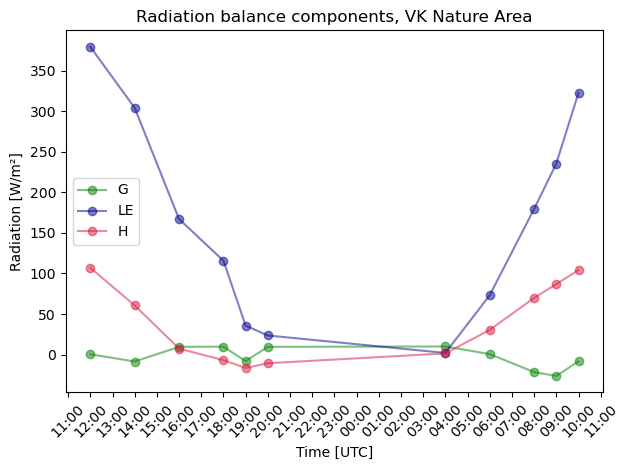

In [259]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# plt.plot(df.index, df['G'], label='G', marker='o',  alpha=0.5, color='brown')
# plt.plot(df.index, df['LE'], label='LE', marker='o', alpha=0.5, color='cyan')
# #plt.plot(df.index, df['Sn'], label='Sn',  marker='o', alpha=0.5)
# plt.plot(df.index, df['H'], label='H', marker='o',alpha=0.5, color='pink')
# # plt.plot(df.index, df['Lout'], label='Lout',marker='o', alpha=0.5, color='green')
# # #plt.plot(df.index, df['Ln'], label='Ln',marker='o', alpha=0.5)
# # plt.plot(df.index, df['Rn'], label='Rn',marker='o', alpha=1, color='black')
plt.xticks(rotation=45)
plt.ylabel('Radiation [W/m2]')
plt.xlabel('time')
plt.title('Energy balance components, VK Nature Area')

plt.legend()

# Copy the original DataFrame
df = EB_VK_tallgrass.copy()

# STEP 1: Round the index and assign it as a new column
df['rounded_time'] = df.index.round('H')

# STEP 2: Set it as the index (if you want plotting to reflect it)
df = df.set_index('rounded_time')

# STEP 3: Optionally group by the new rounded index to avoid duplicate x-values
df = df.groupby(df.index).mean(numeric_only=True)

# STEP 4: Plot
plt.plot(df.index, df['G'], label='G', marker='o',  alpha=0.5, color='green')
plt.plot(df.index, df['LE'], label='LE', marker='o', alpha=0.5, color='darkblue')
plt.plot(df.index, df['H'], label='H', marker='o',alpha=0.5, color='crimson')

# Format x-axis to show only hour and minute
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Optional: set major ticks every hour
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))

plt.xticks(rotation=45)
plt.ylabel('Radiation [W/m²]')
plt.xlabel('Time [UTC]')
plt.title('Radiation balance components, VK Nature Area')
plt.legend()
plt.tight_layout()
plt.show()

# plt.xticks(rotation=45)
# plt.ylabel('Radiation [W/m²]')
# plt.xlabel('Time')
# plt.title('Radiation balance components, VK Nature Area')
# plt.legend()
# plt.tight_layout()
# plt.show()


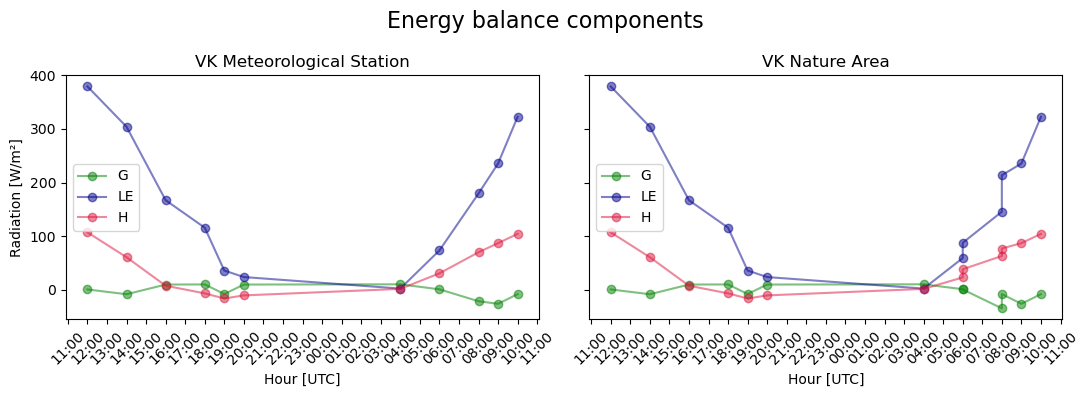

In [265]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume df1 and df2 are your two DataFrames, both indexed by rounded datetime
df1=EB_VK_shortgrass
df2=EB_VK_tallgrass
fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=True)  # 1 row, 2 columns

# Plot for df1 on axes[0]

axes[0].plot(df.index, df['G'], label='G', marker='o',  alpha=0.5, color='green')
axes[0].plot(df.index, df['LE'], label='LE', marker='o', alpha=0.5, color='darkblue')
axes[0].plot(df.index, df['H'], label='H', marker='o',alpha=0.5, color='crimson')

axes[0].set_title('VK Meteorological Station')
axes[0].set_ylabel('Radiation [W/m²]')
axes[0].set_xlabel('Hour [UTC]')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Plot for df2 on axes[1]
axes[1].plot(df2.index, df2['G'], label='G', marker='o',  alpha=0.5, color='green')
axes[1].plot(df2.index, df2['LE'], label='LE', marker='o', alpha=0.5, color='darkblue')
axes[1].plot(df2.index, df2['H'], label='H', marker='o',alpha=0.5, color='crimson')

axes[1].set_title('VK Nature Area')
axes[1].set_xlabel('Hour [UTC]')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[1].xaxis.set_major_locator(mdates.HourLocator(interval=1))

fig.suptitle('Energy balance components', fontsize=16)


plt.tight_layout()
plt.show()


In [249]:
pd.set_option('display.max_rows', 100)
merged_df_mobrad_copy_15min_avg

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,340.500000,-20.450122,-1.699690,51.981701,5.621392,168.0,1138.823529,30.088235,861.383647,140.103735,365.458356,479.631305,721.279912,-114.172949,607.106963,0.163493,30.118421,5.658333,172.376344,-1.142353,61.411931,180.399766,NaN
2025-06-17 11:45:00,852.000000,53.667600,37.223679,51.982027,5.622490,168.0,1147.376093,28.434402,865.133615,122.573085,365.269156,488.112351,742.560531,-122.843195,619.717335,0.141724,31.449346,14.183333,468.142279,0.321581,61.362498,184.428222,NaN
2025-06-17 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 12:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 12:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 12:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-17 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


C:\Users\48512\AppData\Local\Temp\ipykernel_7216\4100653209.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.index = df.index.round('H')
C:\Users\48512\AppData\Local\Temp\ipykernel_7216\4100653209.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df.index.round('H'), df['Sin'], label='Sin', marker='o',  alpha=0.5, color='red')
C:\Users\48512\AppData\Local\Temp\ipykernel_7216\4100653209.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df.index.round('H'), df['Sout'], label='Sout', marker='o', alpha=0.5, color='yellow')
C:\Users\48512\AppData\Local\Temp\ipykernel_7216\4100653209.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(df.index.round('H'), df['Lin'], label='Lin', marker='o',alpha=0.5, color='blue')
C:\Users\48512\AppData\Local

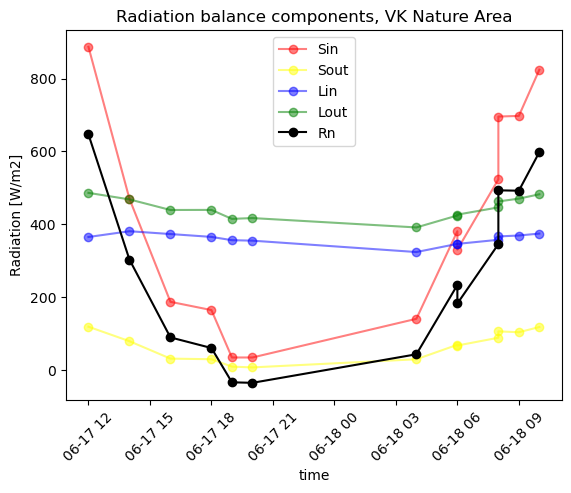

In [187]:
# PLotting the simple time series of the radiation balance components
# I droppend too many NaNs, I shuld fix this later

df = EB_VK_tallgrass

plt.plot(df.index.round('H'), df['Sin'], label='Sin', marker='o',  alpha=0.5, color='red')
plt.plot(df.index.round('H'), df['Sout'], label='Sout', marker='o', alpha=0.5, color='yellow')
#plt.plot(df.index, df['Sn'], label='Sn',  marker='o', alpha=0.5)
plt.plot(df.index.round('H'), df['Lin'], label='Lin', marker='o',alpha=0.5, color='blue')
plt.plot(df.index.round('H'), df['Lout'], label='Lout',marker='o', alpha=0.5, color='green')
#plt.plot(df.index, df['Ln'], label='Ln',marker='o', alpha=0.5)
plt.plot(df.index.round('H'), df['Rn'], label='Rn',marker='o', alpha=1, color='black')
plt.xticks(rotation=45)
plt.ylabel('Radiation [W/m2]')
plt.xlabel('time')
plt.title('Radiation balance components, VK Nature Area')

plt.legend()

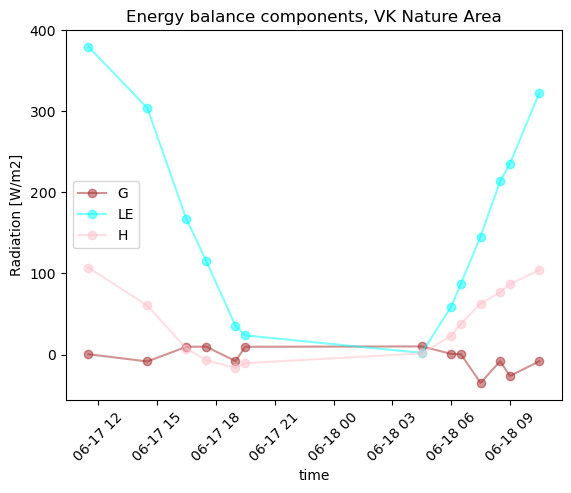

In [49]:
# PLotting the simple time series of the energy balance components
# I droppend too many NaNs, I shuld fix this later

df = EB_VK_tallgrass
plt.plot(df.index, df['G'], label='G', marker='o',  alpha=0.5, color='brown')
plt.plot(df.index, df['LE'], label='LE', marker='o', alpha=0.5, color='cyan')
#plt.plot(df.index, df['Sn'], label='Sn',  marker='o', alpha=0.5)
plt.plot(df.index, df['H'], label='H', marker='o',alpha=0.5, color='pink')
# plt.plot(df.index, df['Lout'], label='Lout',marker='o', alpha=0.5, color='green')
# #plt.plot(df.index, df['Ln'], label='Ln',marker='o', alpha=0.5)
# plt.plot(df.index, df['Rn'], label='Rn',marker='o', alpha=1, color='black')
plt.xticks(rotation=45)
plt.ylabel('Radiation [W/m2]')
plt.xlabel('time')
plt.title('Energy balance components, VK Nature Area')

plt.legend()

In [51]:
shortgrass_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:33:40,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN
2025-06-17 11:33:41,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN
2025-06-17 11:33:42,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN
2025-06-17 11:33:43,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN
2025-06-17 11:33:44,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 10:41:39,672,8.708681,-6.368187,51.981640,5.621790,169,1041,39,811.83,150.43,376.187621,481.917621,661.40,-105.730,555.670,0.185297,30.481928,11.183333,521.938246,-6.0,59.418826,153.624902,NaN
2025-06-18 10:41:40,673,7.995667,-5.650639,51.981647,5.621780,169,1041,40,815.49,150.66,376.289509,482.452509,664.83,-106.163,558.667,0.184748,30.566144,11.200000,522.949811,-6.0,59.419957,153.632061,NaN
2025-06-18 10:41:41,674,7.282653,-4.933092,51.981653,5.621770,169,1041,41,815.98,150.56,376.362182,482.369182,665.42,-106.007,559.413,0.184514,30.553029,11.216667,523.961376,-6.0,59.421088,153.639220,NaN


In [52]:
EB_VK_shortgrass

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691
2025-06-17 14:30:00,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051
2025-06-17 16:30:00,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,168.6873,1,36000,35998,-0.137844,0,-5.421720,2,163.2260,0.0,-6.28958,0.0,3.705150,0.0,-1.430060,

In [53]:
# Now I want to see if there are differences between the tall and short grass in the EB and Rb
columns_of_interest = ['Sin', 'Sout', 'Sn', 'Lin', 'Lout', 'Ln', 'Rn', 'albedo']

# tall grass summary statistics
summary_stats_tall = tallgrass_mobrad[columns_of_interest].describe()
print(summary_stats_tall)

               Sin         Sout           Sn          Lin         Lout  \
count  4350.000000  4350.000000  4350.000000  4350.000000  4350.000000   
mean    427.613699    67.774054   359.839645   361.845324   446.906192   
std     284.411719    39.975402   246.615951    17.012566    29.807974   
min      27.840000     3.435400    16.264000   322.690886   387.967482   
25%     169.620000    31.075000   139.941000   355.736298   425.096310   
50%     377.075000    65.515500   317.183500   365.729782   445.135517   
75%     696.907500   106.547500   590.039500   373.562228   471.573863   
max     947.970000   143.630000   830.600000   384.689112   508.654410   

                Ln           Rn       albedo  
count  4350.000000  4350.000000  4350.000000  
mean    -85.060868   274.778777     0.174333  
std      18.881425   228.907178     0.045360  
min    -143.167000   -43.364200     0.088856  
25%     -98.583750    66.121300     0.144661  
50%     -81.114400   235.465600     0.164726  
75% 

In [54]:
# Short grass sumarry statistics
summary_stats_short = shortgrass_mobrad[columns_of_interest].describe()
print(summary_stats_short)

               Sin         Sout           Sn          Lin         Lout  \
count  4156.000000  4156.000000  4156.000000  4156.000000  4156.000000   
mean    443.901787    89.207221   354.694567   360.327711   444.141626   
std     282.506944    51.930131   232.553069    16.523201    30.305352   
min      27.474000     6.691600    17.193000   321.801435   380.509776   
25%     180.580000    36.759000   141.799000   354.780229   422.990252   
50%     434.975000    95.763500   337.958500   365.846054   445.310221   
75%     687.930000   136.972500   551.767500   372.292504   471.867389   
max     937.990000   188.870000   790.440000   385.732904   492.102260   

                Ln           Rn       albedo  
count  4156.000000  4156.000000  4156.000000  
mean    -83.813915   270.880652     0.212597  
std      19.480708   213.779225     0.033329  
min    -127.547000   -33.903000     0.142216  
25%    -100.405750    73.979950     0.188184  
50%     -85.346300   253.205000     0.210044  
75% 

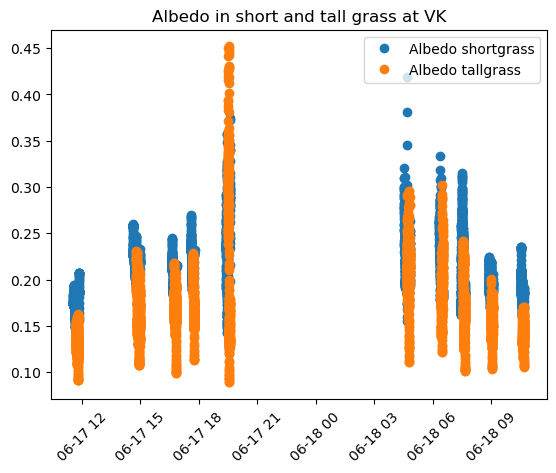

In [55]:
# Quick plot to see the differences in albedo in the two sub-domains

shortgrass_albedo = shortgrass_mobrad['Sout']/shortgrass_mobrad['Sin']
plt.plot(shortgrass_mobrad.index, shortgrass_albedo, label = "Albedo shortgrass", marker='o', linestyle='None')

tallgrass_albedo = tallgrass_mobrad['Sout']/tallgrass_mobrad['Sin']
plt.plot(tallgrass_mobrad.index, tallgrass_albedo, label = "Albedo tallgrass", marker='o', linestyle='None')
plt.xticks(rotation=45)
plt.title("Albedo in short and tall grass at VK")
plt.legend()

In [56]:
albedo_tall_diff = tallgrass_albedo - tallgrass_mobrad['albedo']
albedo_tall_diff.sum()

1.1885655654131355e-09

In [57]:
shortgrass_mobrad['albedo']

datetime
2025-06-17 11:33:40    0.174230
2025-06-17 11:33:41    0.174297
2025-06-17 11:33:42    0.174266
2025-06-17 11:33:43    0.174201
2025-06-17 11:33:44    0.174289
                         ...   
2025-06-18 10:41:39    0.185297
2025-06-18 10:41:40    0.184748
2025-06-18 10:41:41    0.184514
2025-06-18 10:41:42    0.185158
2025-06-18 10:41:43    0.185359
Name: albedo, Length: 4156, dtype: float64

In [58]:
# Checking if there are significant differences between variabled in tall and short grass

# Settings
variable = 'Sin'
# End settings

stat, p = ttest_ind(shortgrass_mobrad[f'{variable}'], tallgrass_mobrad[f'{variable}'], equal_var=False)
print(f"T-test {variable}: stat={stat:.2f}, p={p:.6f}")


T-test Sin: stat=2.65, p=0.008081


In [59]:
# Settings specific to albedo (a lot of NaNs)
# Remove NaN values from each group's albedo data
albedo_short_clean = shortgrass_mobrad['albedo'].dropna()
albedo_tall_clean = tallgrass_mobrad['albedo'].dropna()

# End settings

stat, p = ttest_ind(albedo_short_clean, albedo_tall_clean, equal_var=False)
print(f"T-test {variable}: stat={stat:.2f}, p={p:.6f}")

T-test Sin: stat=44.47, p=0.000000


In [60]:
shortgrass_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:33:40,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN
2025-06-17 11:33:41,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN
2025-06-17 11:33:42,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN
2025-06-17 11:33:43,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN
2025-06-17 11:33:44,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 10:41:39,672,8.708681,-6.368187,51.981640,5.621790,169,1041,39,811.83,150.43,376.187621,481.917621,661.40,-105.730,555.670,0.185297,30.481928,11.183333,521.938246,-6.0,59.418826,153.624902,NaN
2025-06-18 10:41:40,673,7.995667,-5.650639,51.981647,5.621780,169,1041,40,815.49,150.66,376.289509,482.452509,664.83,-106.163,558.667,0.184748,30.566144,11.200000,522.949811,-6.0,59.419957,153.632061,NaN
2025-06-18 10:41:41,674,7.282653,-4.933092,51.981653,5.621770,169,1041,41,815.98,150.56,376.362182,482.369182,665.42,-106.007,559.413,0.184514,30.553029,11.216667,523.961376,-6.0,59.421088,153.639220,NaN


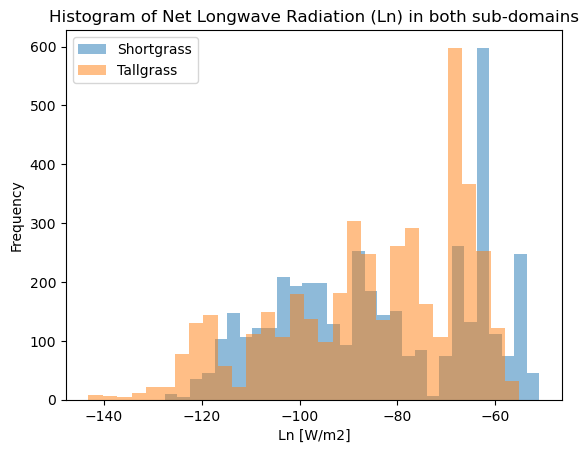

In [61]:
plt.hist(shortgrass_mobrad['Ln'], alpha=0.5, label="Shortgrass", bins=30)
plt.title('Longwave incoming shortgrass')

plt.hist(tallgrass_mobrad['Ln'], alpha=0.5, label="Tallgrass", bins=30)
plt.title('Histogram of Net Longwave Radiation (Ln) in both sub-domains')
plt.xlabel('Ln [W/m2]')
plt.ylabel('Frequency')
plt.legend()

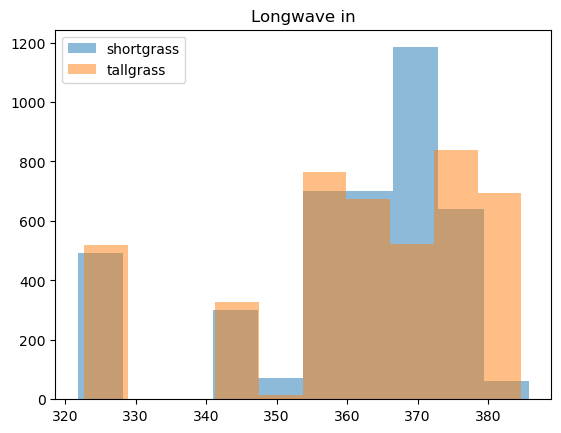

In [62]:
plt.hist(shortgrass_mobrad['Lin'], alpha=0.5, label="shortgrass")
plt.title('Longwave incoming shortgrass')

plt.hist(tallgrass_mobrad['Lin'], alpha=0.5, label="tallgrass")
plt.title('Longwave in')
plt.legend()

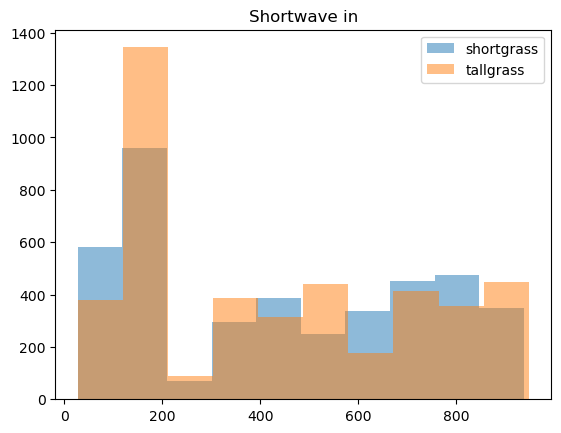

In [63]:
plt.hist(shortgrass_mobrad['Sin'], alpha=0.5, label="shortgrass")
plt.title('Shortwave incoming shortgrass')

plt.hist(tallgrass_mobrad['Sin'], alpha=0.5, label="tallgrass")
plt.title('Shortwave in')
plt.legend()

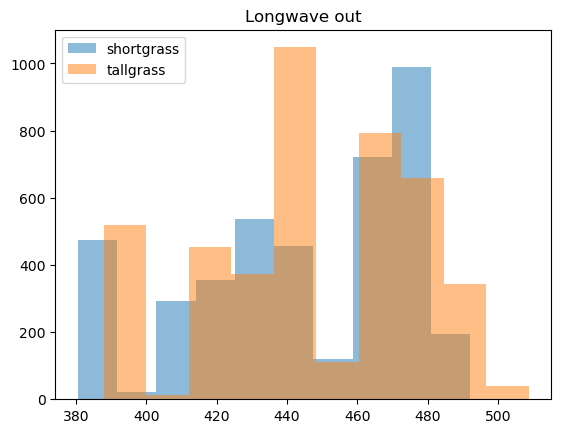

In [64]:
plt.hist(shortgrass_mobrad['Lout'], alpha=0.5, label="shortgrass")
plt.title('Longwave incoming shortgrass')

plt.hist(tallgrass_mobrad['Lout'], alpha=0.5, label="tallgrass")
plt.title('Longwave out')
plt.legend()

Text(0, 0.5, '')

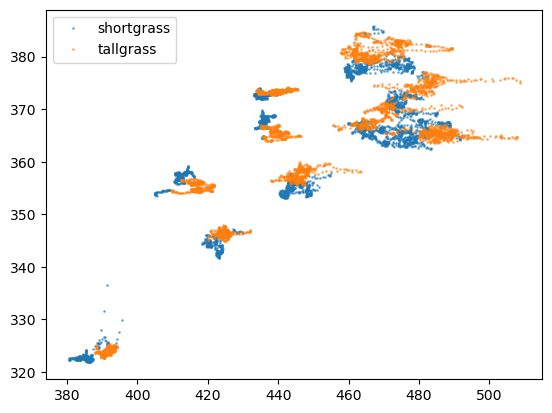

In [65]:
plt.plot(shortgrass_mobrad['Lout'], shortgrass_mobrad['Lin'], marker = "o", label="shortgrass", markersize=1, alpha=0.5, linestyle ='None')
plt.plot(tallgrass_mobrad['Lout'], tallgrass_mobrad['Lin'], marker = "o", label="tallgrass", markersize=1, alpha=0.5, linestyle = 'None')
plt.legend()
plt.xlabel('')
plt.ylabel('')

Text(0.5, 1.0, 'Sin tall/short gras')

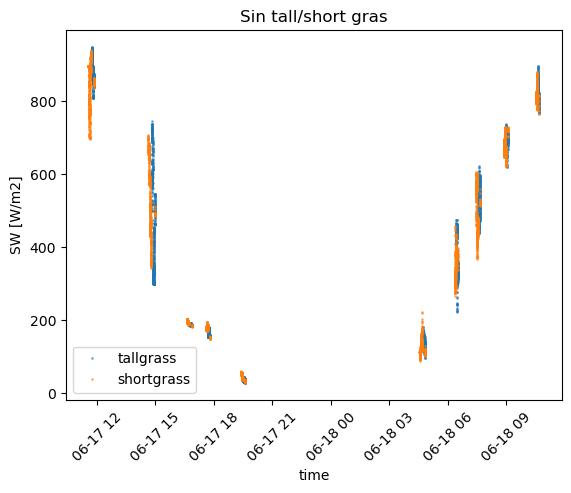

In [66]:
plt.plot(tallgrass_mobrad.index, tallgrass_mobrad['Sin'], label='tallgrass', marker='o', markersize=1, linestyle='None', alpha=0.5)
plt.plot(shortgrass_mobrad.index, shortgrass_mobrad['Sin'], label='shortgrass', marker='o', markersize=1, linestyle='None', alpha=0.5)
plt.xticks(rotation=45)
plt.ylabel('SW [W/m2]')
plt.xlabel('time')
plt.legend()
plt.title('Sin tall/short gras')

In [68]:
# Notes for later. I assume p <= 0.05 for significance
# Sin stat=5.26, p=0.000, different
# Sout stat=22.27, p=0.000, different
# Sn stat=1.74, p=0.082, not different
# Lin, stat=1.07, p=0.285, not different
# Lout  stat=-1.64, p=0.102, not different
# Ln, stat=3.79, p=0.000, different
# Rn stat=2.27, p=0.023, different
# albedo p=0.000, different


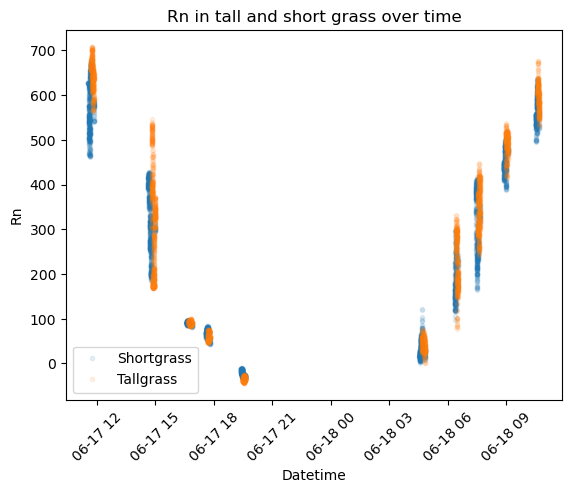

In [69]:
# Simple plotting to compare one variable of the tall and short grass df over time

# Plotting settings
variable = 'Rn'
# End plotting settings

plt.plot(shortgrass_mobrad.index, shortgrass_mobrad[variable], linestyle='None', alpha=0.1, marker='o', markersize=3, label='Shortgrass')
plt.plot(tallgrass_mobrad.index, tallgrass_mobrad[variable], linestyle='None', alpha=0.1, marker='o', markersize=3, label='Tallgrass')


plt.legend()
plt.xlabel('Datetime')
plt.ylabel(variable)
plt.title(f'{variable} in tall and short grass over time')
plt.xticks(rotation=45) 
plt.show()

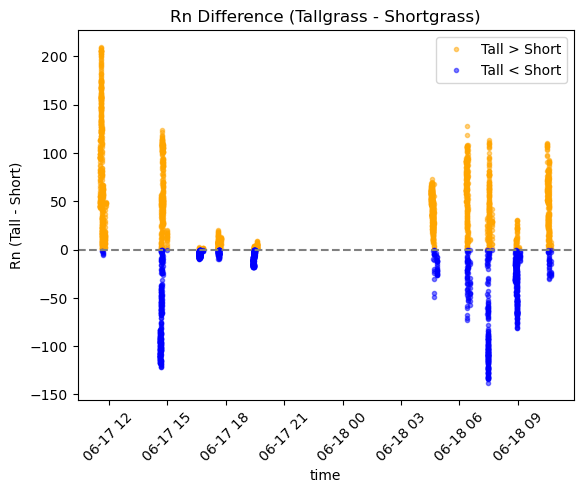

In [93]:
# Plotting the difference in one variable in the tall and short grass

# Plotting settings
variable = "Rn"
# End plotting settings

# # Sort both DataFrames by datetime
# shortgrass_mobrad = shortgrass_mobrad.sort_values('datetime')
# tallgrass_mobrad = tallgrass_mobrad.sort_values('datetime')

# # Perform asof merge with x-minute tolerance
# merged = pd.merge_asof(
#     shortgrass_mobrad[['datetime', variable]],
#     tallgrass_mobrad[['datetime', variable]],
#     on='datetime',
#     tolerance=pd.Timedelta('50min'),
#     direction='nearest',
#     suffixes=('_short', '_tall')
# )

# Make sure index is sorted
shortgrass_mobrad = shortgrass_mobrad.sort_index()
tallgrass_mobrad = tallgrass_mobrad.sort_index()

merged = pd.merge_asof(
    shortgrass_mobrad[[variable]],
    tallgrass_mobrad[[variable]],
    tolerance=pd.Timedelta('50min'),
    direction='nearest',
    suffixes=('_short', '_tall'),
    left_index=True,
    right_index=True
)


# Drop rows where no tallgrass match was found
merged = merged.dropna(subset=[f'{variable}_tall'])

# Calculate difference
merged[f'{variable}_diff'] = merged[f'{variable}_tall'] - merged[f'{variable}_short']

# Plot positive differences (orange)

pos = merged[merged[f'{variable}_diff'] > 0]
plt.plot(
    pos.index, pos[f'{variable}_diff'],
    linestyle='None', marker='o', alpha=0.5, markersize=3, color='orange', label='Tall > Short'
)

# Plot negative differences (blue)
neg = merged[merged[f'{variable}_diff'] < 0]
plt.plot(
    neg.index, neg[f'{variable}_diff'],
    linestyle='None', marker='o', alpha=0.5, markersize=3, color='blue', label='Tall < Short'
)

# Dashed horizontal line at 0
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('time')
plt.ylabel(f'{variable} (Tall - Short)')
plt.title(f'{variable} Difference (Tallgrass - Shortgrass)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# ### Next Fig.

# plt.figure(figsize=(12, 5))

# plt.plot(merged['datetime'], merged[f'{variable}_short'], label=f'Short Grass {variable}', color='green')
# plt.plot(merged['datetime'], merged[f'{variable}_tall'], label=f'Tall Grass {variable}', color='brown')

# plt.fill_between(merged['datetime'],
#                  merged[f'{variable}_short'],
#                  merged[f'{variable}_tall'],
#                  where=(merged[f'{variable}_short'] > merged[f'{variable}_tall']),
#                  color='green', alpha=0.3, interpolate=True, label='Short > Tall')

# plt.fill_between(merged['datetime'],
#                  merged[f'{variable}_short'],
#                  merged[f'{variable}_tall'],
#                  where=(merged[f'{variable}_short'] <= merged[f'{variable}_tall']),
#                  color='brown', alpha=0.3, interpolate=True, label='Tall ≥ Short')

# plt.xlabel('Time')
# plt.ylabel(f'{variable} (W/m²)')
# plt.title(f'{variable}: Short vs Tall Grass with Shaded Differences')
# plt.legend()
# plt.tight_layout()
# plt.show()


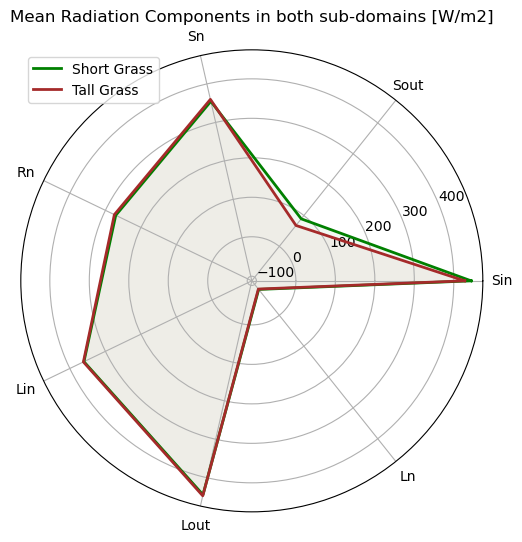

In [94]:
categories = ['Sin', 'Sout', 'Sn', 'Rn', 'Lin', 'Lout', 'Ln']

short_means = [shortgrass_mobrad[col].mean() for col in categories]
tall_means = [tallgrass_mobrad[col].mean() for col in categories]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
short_means += short_means[:1]  # wrap around for closed circle
tall_means += tall_means[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, short_means, label='Short Grass', color='green', linewidth=2)
ax.fill(angles, short_means, color='green', alpha=0.05)
ax.plot(angles, tall_means, label='Tall Grass', color='brown', linewidth=2)
ax.fill(angles, tall_means, color='brown', alpha=0.05)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Mean Radiation Components in both sub-domains [W/m2]')
ax.legend(loc='upper left')
plt.show()


In [96]:
shortgrass_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:33:40,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN
2025-06-17 11:33:41,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN
2025-06-17 11:33:42,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN
2025-06-17 11:33:43,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN
2025-06-17 11:33:44,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 10:41:39,672,8.708681,-6.368187,51.981640,5.621790,169,1041,39,811.83,150.43,376.187621,481.917621,661.40,-105.730,555.670,0.185297,30.481928,11.183333,521.938246,-6.0,59.418826,153.624902,NaN
2025-06-18 10:41:40,673,7.995667,-5.650639,51.981647,5.621780,169,1041,40,815.49,150.66,376.289509,482.452509,664.83,-106.163,558.667,0.184748,30.566144,11.200000,522.949811,-6.0,59.419957,153.632061,NaN
2025-06-18 10:41:41,674,7.282653,-4.933092,51.981653,5.621770,169,1041,41,815.98,150.56,376.362182,482.369182,665.42,-106.007,559.413,0.184514,30.553029,11.216667,523.961376,-6.0,59.421088,153.639220,NaN


In [106]:
# shortgrass_mobrad['hour'] = shortgrass_mobrad.index.dt.hour
# tallgrass_mobrad['hour'] = tallgrass_mobrad.index.dt.hour

hourly_means_short = shortgrass_mobrad.resample('H').mean()
hourly_means_tall = tallgrass_mobrad.resample('H').mean()


# short_hourly = shortgrass_mobrad.groupby('hour')['Rn'].mean()
# tall_hourly = tallgrass_mobrad.groupby('hour')['Rn'].mean()

hourly_df = pd.DataFrame({'Short Grass': hourly_means_short, 'Tall Grass': hourly_means_tall})

plt.figure(figsize=(10, 4))
sns.heatmap(hourly_df.T, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Net Radiation (W/m²)'})
plt.title('Hourly Mean Net Radiation for Short vs Tall Grass')
plt.xlabel('Hour of Day')
plt.show()


C:\Users\48512\AppData\Local\Temp\ipykernel_7216\1454168845.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_means_short = shortgrass_mobrad.resample('H').mean()
C:\Users\48512\AppData\Local\Temp\ipykernel_7216\1454168845.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_means_tall = tallgrass_mobrad.resample('H').mean()


ValueError: If using all scalar values, you must pass an index

In [269]:
shortgrass_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22
datetime,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:33:40,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN
2025-06-17 11:33:41,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN
2025-06-17 11:33:42,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN
2025-06-17 11:33:43,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN
2025-06-17 11:33:44,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 10:41:39,672,8.708681,-6.368187,51.981640,5.621790,169,1041,39,811.83,150.43,376.187621,481.917621,661.40,-105.730,555.670,0.185297,30.481928,11.183333,521.938246,-6.0,59.418826,153.624902,NaN
2025-06-18 10:41:40,673,7.995667,-5.650639,51.981647,5.621780,169,1041,40,815.49,150.66,376.289509,482.452509,664.83,-106.163,558.667,0.184748,30.566144,11.200000,522.949811,-6.0,59.419957,153.632061,NaN
2025-06-18 10:41:41,674,7.282653,-4.933092,51.981653,5.621770,169,1041,41,815.98,150.56,376.362182,482.369182,665.42,-106.007,559.413,0.184514,30.553029,11.216667,523.961376,-6.0,59.421088,153.639220,NaN


In [271]:
# Add hour column
shortgrass_mobrad['hour'] = shortgrass_mobrad.index.dt.hour
tallgrass_mobrad['hour'] = tallgrass_mobrad.index.dt.hour

# Variables you want to compare
variables = ['Sin', 'Sout', 'Sn', 'Lin', 'Lout', 'Ln', 'Rn']

# Compute hourly means for short grass
short_hourly = shortgrass_mobrad.groupby('hour')[variables].mean()
# Compute hourly means for tall grass
tall_hourly = tallgrass_mobrad.groupby('hour')[variables].mean()

# Build combined DataFrame
hourly_df = pd.concat(
    { 'Short Grass': short_hourly, 'Tall Grass': tall_hourly },
    names=['Grass Type', 'Hour']
).reset_index()

# Pivot for heatmap (one heatmap per variable)
for var in variables:
    heatmap_data = hourly_df.pivot(index='Grass Type', columns='Hour', values=var)
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': f'{var} (W/m²)'})
    plt.title(f'Hourly Mean {var} for Short vs Tall Grass')
    plt.xlabel('Hour of Day')
    plt.ylabel('')
    plt.show()


AttributeError: 'DatetimeIndex' object has no attribute 'dt'

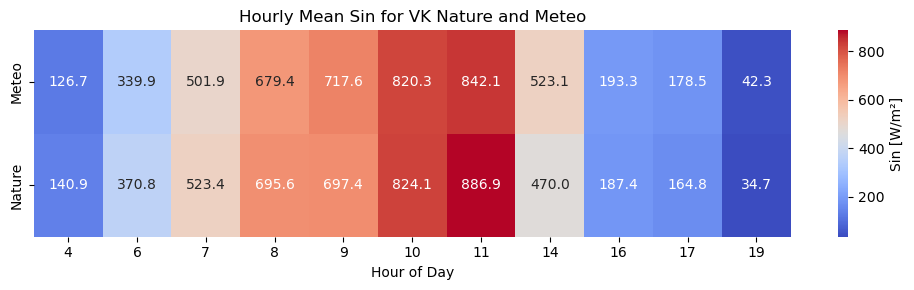

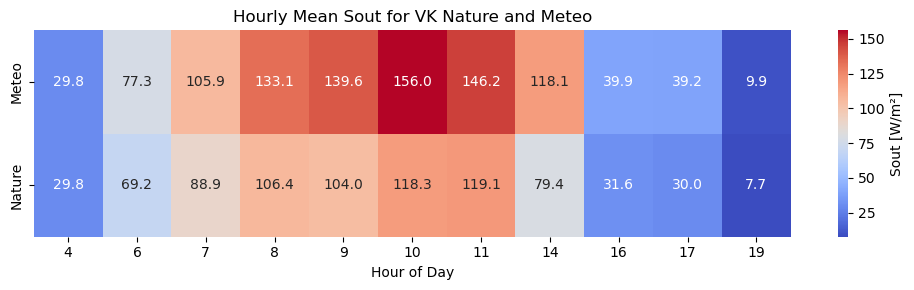

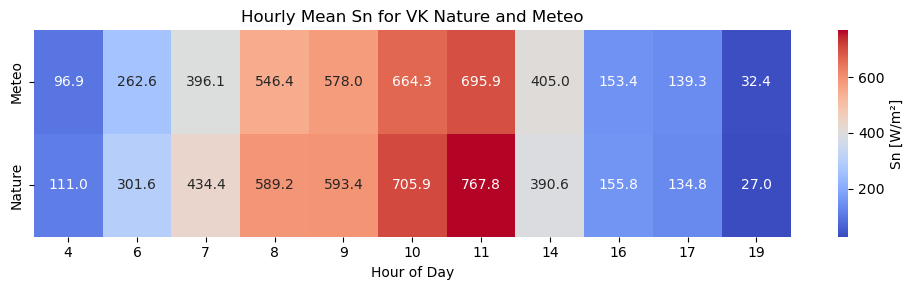

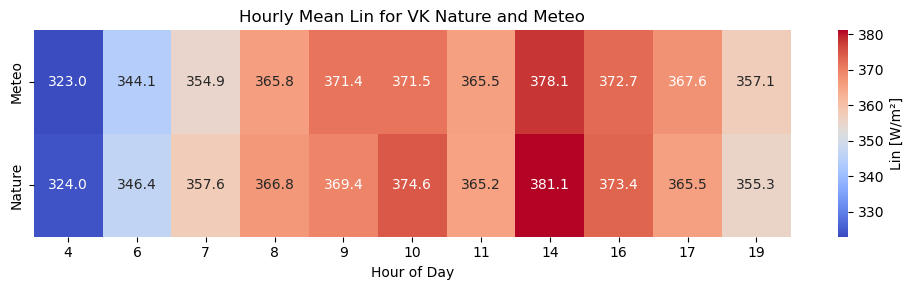

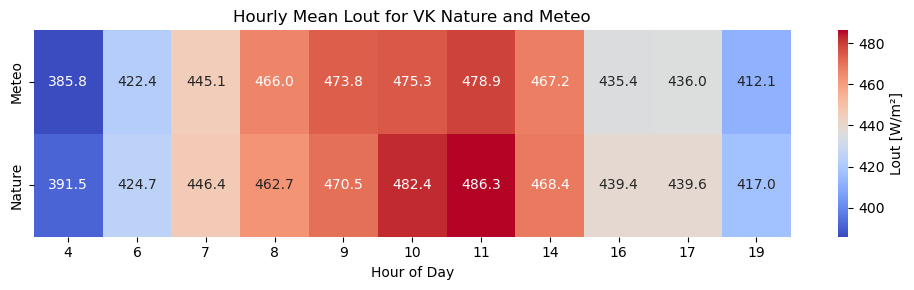

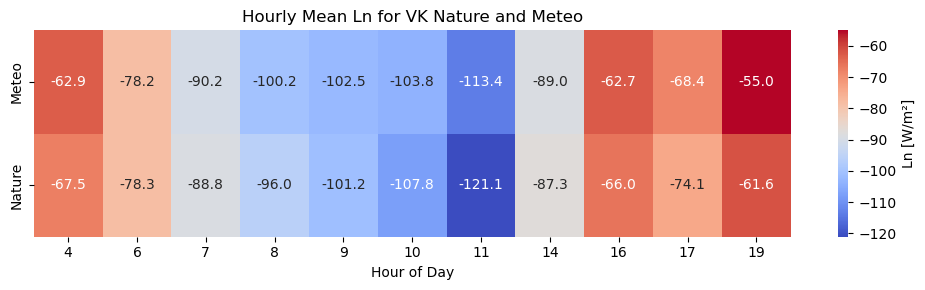

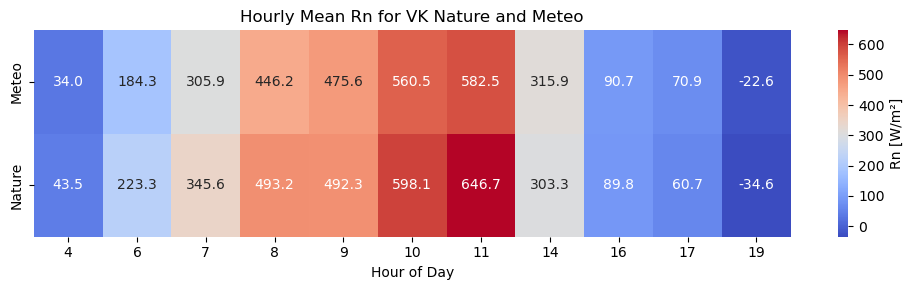

In [285]:
# Add 'hour' column using datetime index
shortgrass_mobrad['hour'] = shortgrass_mobrad.index.hour
tallgrass_mobrad['hour'] = tallgrass_mobrad.index.hour

# Variables to compare
variables = ['Sin', 'Sout', 'Sn', 'Lin', 'Lout', 'Ln', 'Rn']

# Compute hourly means
short_hourly = shortgrass_mobrad.groupby('hour')[variables].mean()
tall_hourly = tallgrass_mobrad.groupby('hour')[variables].mean()

# Combine for plotting
hourly_df = pd.concat(
    {'Meteo': short_hourly, 'Nature': tall_hourly},
    names=['Grass Type', 'Hour']
).reset_index()

# Plot heatmaps
for var in variables:
    heatmap_data = hourly_df.pivot(index='Grass Type', columns='Hour', values=var)
    
    plt.figure(figsize=(10, 3))
    sns.heatmap(
        heatmap_data,
        cmap='coolwarm', annot=True, fmt=".1f",
        cbar_kws={'label': f'{var} [W/m²]'}
    )
    plt.title(f'Hourly Mean {var} for VK Nature and Meteo')
    plt.xlabel('Hour of Day')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

C:\Users\48512\AppData\Local\Temp\ipykernel_7216\3154328537.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='grass', y='Rn', data=combined, palette=['blue', 'orange'])


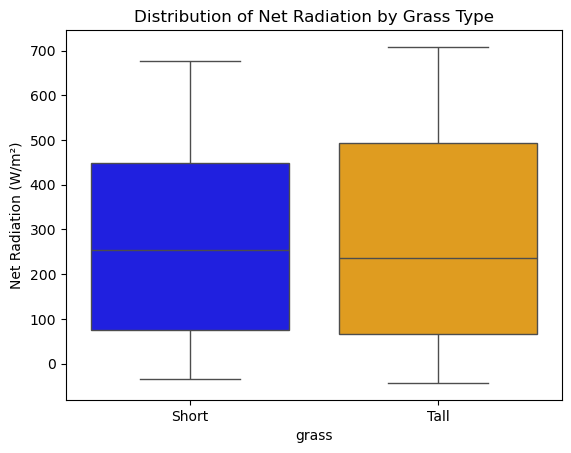

In [110]:
combined = pd.concat([
    shortgrass_mobrad.assign(grass='Short'),
    tallgrass_mobrad.assign(grass='Tall')
])
sns.boxplot(x='grass', y='Rn', data=combined, palette=['blue', 'orange'])
plt.title('Distribution of Net Radiation by Grass Type')
plt.ylabel('Net Radiation (W/m²)')
plt.show()


In [102]:
###### END RADIATION BALANCE ######
# Still missing RB for 2 domains in Loobos, to do tomorrow

In [104]:
###### ENERGY BALANCE ######

In [ ]:
### VK short grass EB closure ###

In [118]:
EB_VK_shortgrass

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691
2025-06-17 14:30:00,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051
2025-06-17 16:30:00,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,168.6873,1,36000,35998,-0.137844,0,-5.421720,2,163.2260,0.0,-6.28958,0.0,3.705150,0.0,-1.430060,

In [120]:
# Skipping rows of data where H, LE or G are NaN
# EB_VK_shortgrass = EB_VK_shortgrass.dropna(subset=['G1(W/m2)', 'LE', 'H'])
# EB_VK_tallgrass = EB_VK_tallgrass.dropna(subset=['G1(W/m2)', 'LE', 'H'])

In [124]:
EB_VK_shortgrass['Q*'] = EB_VK_shortgrass['H'] + EB_VK_shortgrass['LE'] + EB_VK_shortgrass['G'] # How much energy is comming/escaping the system

EB_VK_tallgrass['Q*'] = EB_VK_tallgrass['H'] + EB_VK_tallgrass['LE'] + EB_VK_tallgrass['G'] # How much energy is comming/escaping the system


In [ ]:
energy_dif
total = energy_dif.sum()
total

Text(0, 0.5, 'Rn - Q* [W/m2]')

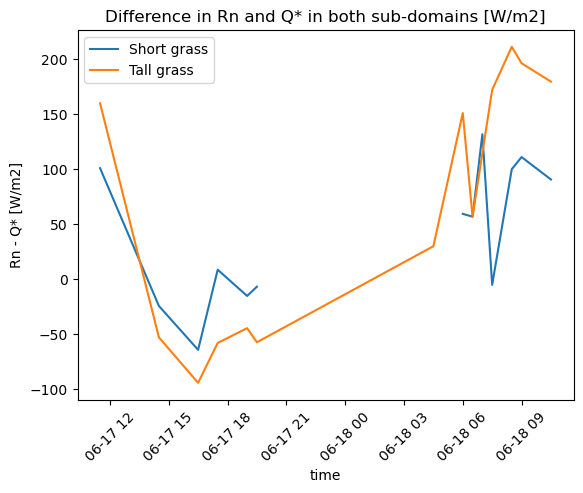

In [128]:
# Is the Q* from energy balance the same as the Q from energy balance?
# Q*en = H + LvE + G = Rn
# Q*rad = s_down + l_down - s_up - l_up


energy_dif_short = EB_VK_shortgrass['Rn'] - EB_VK_shortgrass['Q*']
plt.plot(EB_VK_shortgrass.index, energy_dif_short, label="Short grass")

energy_dif_tall = EB_VK_tallgrass['Rn'] - EB_VK_tallgrass['Q*']
plt.plot(EB_VK_tallgrass.index, energy_dif_tall, label="Tall grass")
plt.title('Difference in Rn and Q* in both sub-domains [W/m2]')
plt.xticks(rotation=45) 
plt.legend()
plt.xlabel('time')
plt.ylabel('Rn - Q* [W/m2]')

Text(0.5, 1.0, 'Difference in Rn and Q* in tallgrass field [W/m2]')

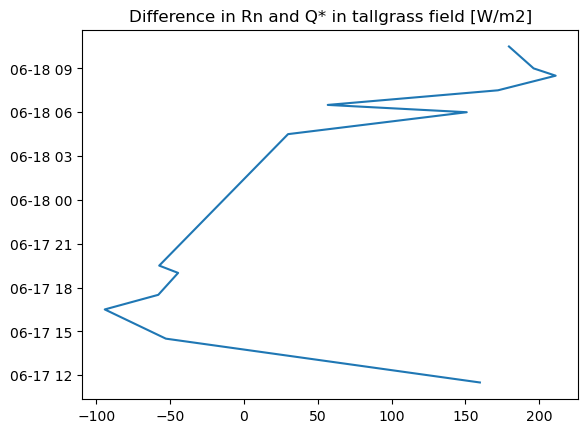

In [130]:
energy_dif = EB_VK_tallgrass['Rn'] - EB_VK_tallgrass['Q*']
plt.plot(energy_dif, EB_VK_tallgrass.index)
plt.title('Difference in Rn and Q* in tallgrass field [W/m2]')

In [ ]:
EB_VK_shortgrass

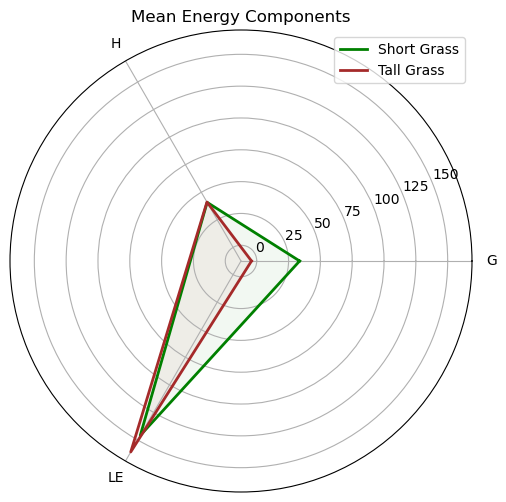

In [138]:
# plot to see how different energy balance are distributed
categories = ['G', 'H', 'LE']

short_means = [EB_VK_shortgrass[col].mean() for col in categories]
tall_means = [EB_VK_tallgrass[col].mean() for col in categories]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
short_means += short_means[:1]  # wrap around for closed circle
tall_means += tall_means[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, short_means, label='Short Grass', color='green', linewidth=2)
ax.fill(angles, short_means, color='green', alpha=0.05)
ax.plot(angles, tall_means, label='Tall Grass', color='brown', linewidth=2)
ax.fill(angles, tall_means, color='brown', alpha=0.05)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title('Mean Energy Components')
ax.legend(loc='upper right')
plt.show()

In [134]:
# Summary, what I already have:
# 1. RB_VK_tallgrass
# 2. EB_VK_shortgrass
# 3. RB_VK_tallgrass
# 4. EB_VK_tallgrass

# What I need to have:
# 3. EB_LB_under/over canopy? Comparison of RB and EB of some other domains


In [140]:
# Calculate correlation
# settings
df = EB_VK_tallgrass
var1 = 'Lin'
var2 = "Lout"
loc = 'shortgrass'
# end settings

correlation = df[var1].corr(df[var2])
print(f'Correlation of {var1} and {var2} in {loc} is {correlation}')

Correlation of Lin and Lout in shortgrass is 0.8054011445198542


In [ ]:
EB_VK_shortgrass

In [ ]:
###### END ENERGY BALANCE ######

In [ ]:
EB_VK_shortgrass

In [ ]:
# Did any specific gropu contributed to the strange results of sw_in_tall not equal to sw_in_short?


In [ ]:
shortgrass_mobrad

In [ ]:
tallgrass_mobrad

In [ ]:
tallgrass_mobrad

In [ ]:
shortgrass_mobrad

In [142]:
# Align df2 to df1 by nearest datetime within a 10-minute tolerance
df2_aligned = shortgrass_mobrad.reindex(t.index, method='nearest', tolerance=pd.Timedelta(minutes=5))

# Subtract (matching columns will be subtracted; rest will be NaNs)
#df_diff = df1 - df2_aligned

NameError: name 't' is not defined

In [ ]:
shortgrass_mobrad['Sin']

In [ ]:
df2_aligned['Sin']

In [144]:
SW_diff = shortgrass_mobrad['Sin'] - df2_aligned['Sin']
SW_diff.dropna()
SW_diff

NameError: name 'df2_aligned' is not defined

In [ ]:
df2_aligned

In [ ]:
EB_VK_shortgrass

In [ ]:
# Additional question, is there temp difference between Nature and Meteo?
EB_VK_shortgrass['Ts'].mean()

In [ ]:
EB_VK_tallgrass['Ts'].mean()

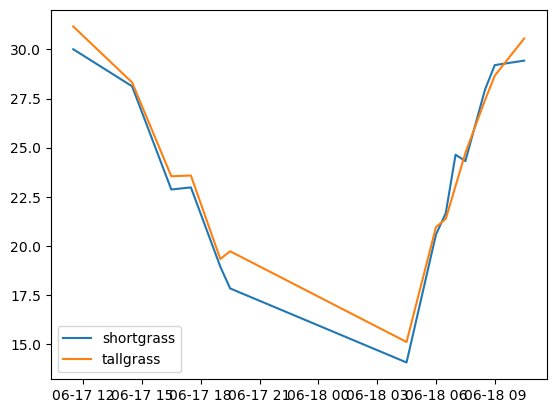

In [146]:
plt.plot(EB_VK_shortgrass.index, EB_VK_shortgrass['Ts'], label='shortgrass')
plt.plot(EB_VK_tallgrass.index, EB_VK_tallgrass['Ts'], label='tallgrass')
plt.legend()

In [ ]:
EB_VK_shortgrass

In [148]:

EB_VK_shortgrass['TaTs'] = (EB_VK_shortgrass['air_temperature']-273.15) - EB_VK_shortgrass['Ts']
EB_VK_shortgrass['TaTs']

datetime
2025-06-17 11:30:00   -6.793130
2025-06-17 14:30:00   -3.633497
2025-06-17 16:30:00    0.517584
2025-06-17 17:30:00   -0.747102
2025-06-17 19:00:00    1.635355
2025-06-17 19:30:00    2.565554
2025-06-18 04:30:00   -1.480895
2025-06-18 06:00:00   -3.484280
2025-06-18 06:30:00   -3.523209
2025-06-18 07:00:00   -5.579393
2025-06-18 07:30:00   -4.269786
2025-06-18 08:30:00   -6.375792
2025-06-18 09:00:00   -6.997691
2025-06-18 10:30:00   -5.786360
Name: TaTs, dtype: float64

Text(0.5, 1.0, 'relationship between H and (Ta-Ts)')

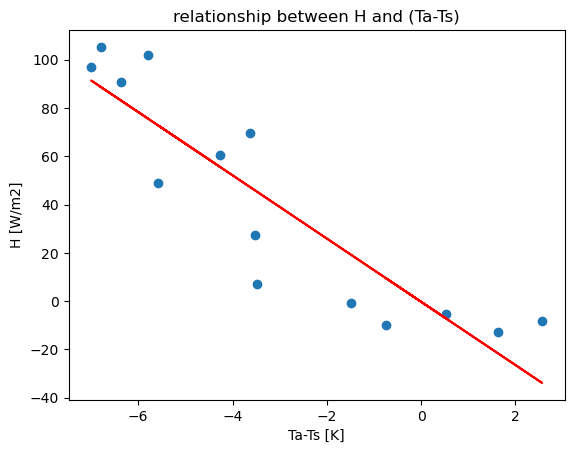

In [141]:
plt.scatter(EB_VK_shortgrass['TaTs'], EB_VK_shortgrass['H'])
plt.xlabel('Ta-Ts [K]')
plt.ylabel('H [W/m2]')

# Fit a linear regression line: y = m*x + b
coeffs = np.polyfit(EB_VK_shortgrass['TaTs'], EB_VK_shortgrass['H'], deg=1)
fit_line = np.poly1d(coeffs)
plt.plot(EB_VK_shortgrass['TaTs'], fit_line(EB_VK_shortgrass['TaTs']), color='red', label='Fit Line')
plt.title('relationship between H and (Ta-Ts)')

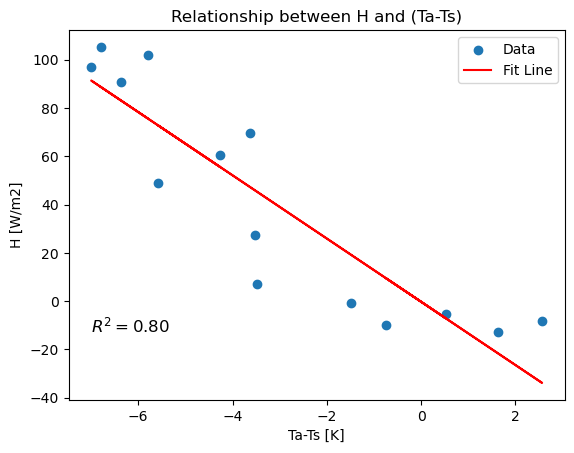

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# Data
x = EB_VK_shortgrass['TaTs']
y = EB_VK_shortgrass['H']

# Linear regression
coeffs = np.polyfit(x, y, 1)
fit_line = np.poly1d(coeffs)
y_pred = fit_line(x)

# R² calculation
r_squared = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

# Plot
plt.scatter(x, y, label='Data')
plt.plot(x, y_pred, color='red', label='Fit Line')
plt.xlabel('Ta-Ts [K]')
plt.ylabel('H [W/m2]')
plt.title('Relationship between H and (Ta-Ts)')

# Add R² to the plot
plt.text(min(x), min(y), f'$R^2 = {r_squared:.2f}$', fontsize=12)
plt.legend()
plt.show()


In [152]:
EB_VK_shortgrass
# I'm looking for ea, esTs

,Index,x,y,lat,lon,DOY_x,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,DOY_y,daytime,file_records,used_records,Tau,qc_Tau,H,qc_H,LE,qc_LE,co2_flux,qc_co2_flux,h2o_flux,qc_h2o_flux,H_strg,LE_strg,co2_strg,h2o_strg,co2_v-adv,h2o_v-adv,co2_molar_density,co2_mole_fraction,co2_mixing_ratio,co2_time_lag,co2_def_timelag,h2o_molar_density,h2o_mole_fraction,h2o_mixing_ratio,h2o_time_lag,h2o_def_timelag,sonic_temperature,air_temperature,air_pressure,air_density,air_heat_capacity,air_molar_volume,ET,water_vapor_density,e,es,specific_humidity,RH,VPD,Tdew,u_unrot,v_unrot,w_unrot,u_rot,v_rot,w_rot,wind_speed,max_wind_speed,wind_dir,yaw,pitch,roll,u*,TKE,L,(z-d)/L,bowen_ratio,T*,model,x_peak,x_offset,x_10%,x_30%,x_50%,x_70%,x_90%,un_Tau,Tau_scf,un_H,H_scf,un_LE,LE_scf,un_co2_flux,co2_scf,un_h2o_flux,h2o_scf,spikes_hf,amplitude_resolution_hf,drop_out_hf,absolute_limits_hf,skewness_kurtosis_hf,skewness_kurtosis_sf,discontinuities_hf,discontinuities_sf,timelag_hf,timelag_sf,attack_angle_hf,non_steady_wind_hf,u_spikes,v_spikes,w_spikes,ts_spikes,co2_spikes,h2o_spikes,chopper_LI-7500,detector_LI-7500,pll_LI-7500,sync_LI-7500,mean_value_AGC_LI-7500,u_var,v_var,w_var,ts_var,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,G,Q*,TaTs
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-06-17 11:30:00,304.737523,-39.758223,-9.255327,51.981640,5.621107,168.0,1138.232902,29.763401,842.097689,146.180148,365.535223,478.933245,695.917542,-113.398022,582.519519,0.173910,30.008130,5.062292,154.541944,-1.293530,61.409287,180.113025,NaN,168.4790,1,36000,35998,-0.059293,1,105.263000,0,288.6990,0.0,-9.81909,0.0,6.552260,0.0,1.183940,0.566578,-0.098863,0.012859,-2.145650e-10,-9.531270e-12,16.2595,397.710,404.862,0.1,1,722.270,17.6668,17.9845,0.1,1,298.028,296.365,101300.0,1.18293,1015.28,0.024460,0.424587,0.013015,1780.08,2836.17,0.011003,62.7635,1056.0900,288.831,1.451400,-2.243950,-0.104285,2.674460,-1.082080e-13,-1.319630e-14,2.674460,7.151810,253.127,302.8950,-2.23469,NaN,0.223884,1.366470,-9.39961,-0.357781,0.364611,-0.391478,0,43.5588,-6.61022,14.9523,37.2334,56.7833,79.6394,119.314,-0.058330,1.01652,119.824000,1.01775,249.1400,1.10064,-15.644800,1.10064,5.654450,1.10064,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,5,2,12,19,22,0,0,0,0,56,1.245340,1.343780,0.143821,0.402884,0.011466,1483.2200,0.099769,-0.015645,5.654450,87.704691,481.666691,-6.793130
2025-06-17 14:30:00,330.805825,-45.791497,-8.552650,51.981621,5.621063,168.0,1442.757282,29.368932,523.101117,118.148092,378.126058,467.156927,404.953024,-89.030869,315.922155,0.223538,28.124497,5.496764,149.051804,-4.368932,44.779161,248.853885,NaN,168.6040,1,36000,35998,-0.063216,0,69.712700,0,246.6630,0.0,-8.67006,0.0,5.605160,0.0,0.368091,0.737289,-0.065536,0.016754,-1.686280e-10,-7.700560e-12,16.0238,393.670,400.877,0.1,1,731.743,17.9773,18.3064,0.1,1,299.341,297.641,101300.0,1.17772,1015.48,0.024568,0.363214,0.013186,1811.19,3062.19,0.011196,59.1469,1251.0000,289.101,1.422710,-2.137880,-0.094087,2.569730,7.185180e-14,-1.052360e-14,2.569730,6.491680,251.252,303.6430,-2.09828,NaN,0.231681,1.005080,-15.72950,-0.213802,0.282623,-0.251596,0,47.8021,-7.25416,16.4089,40.8605,62.3149,87.3975,130.937,-0.062162,1.01695,82.575600,1.01790,214.5050,1.09996,-12.730100,1.09996,4.874410,1.09996,800000099,800000099,800000099,800000099,800000099,800000099,899999999,899999999,89999,89999,89,89,12,15,2,7,23,15,0,0,0,0,56,0.885673,1.002400,0.122076,0.284250,0.010509,1362.0200,0.069046,-0.012730,4.874410,23.849051,340.224751,-3.633497
2025-06-17 16:30:00,204.370370,-47.012718,-2.945923,51.981639,5.621131,168.0,1639.579365,29.608466,193.268280,39.869095,372.668325,435.370607,153.399185,-62.702282,90.696903,0.206129,22.868416,3.389506,144.665307,-1.288360,27.127473,274.001733,NaN,168.6873,1,36000,35998,-0.137844,0,-5.421720

In [154]:
# Le sunny day

# ea - es*Ts
# e - ea
EB_VK_shortgrass['eTs'] = EB_VK_shortgrass['e'] - EB_VK_shortgrass['Ts']
EB_VK_shortgrass['e']

datetime
2025-06-17 11:30:00    1780.08
2025-06-17 14:30:00    1811.19
2025-06-17 16:30:00    1866.93
2025-06-17 17:30:00    1915.18
2025-06-17 19:00:00    1967.10
2025-06-17 19:30:00    1906.91
2025-06-18 04:30:00        NaN
2025-06-18 06:00:00    1964.38
2025-06-18 06:30:00    1979.97
2025-06-18 07:00:00    1969.67
2025-06-18 07:30:00    1961.65
2025-06-18 08:30:00    1944.40
2025-06-18 09:00:00    1952.25
2025-06-18 10:30:00    2009.60
Name: e, dtype: float64

In [156]:
EB_VK_shortgrass['LE']

datetime
2025-06-17 11:30:00    288.6990
2025-06-17 14:30:00    246.6630
2025-06-17 16:30:00    163.2260
2025-06-17 17:30:00     83.2789
2025-06-17 19:00:00     26.2517
2025-06-17 19:30:00     14.3320
2025-06-18 04:30:00         NaN
2025-06-18 06:00:00     79.2941
2025-06-18 06:30:00     84.8192
2025-06-18 07:00:00    111.6800
2025-06-18 07:30:00    136.9500
2025-06-18 08:30:00    184.2680
2025-06-18 09:00:00    192.4680
2025-06-18 10:30:00    284.5770
Name: LE, dtype: float64

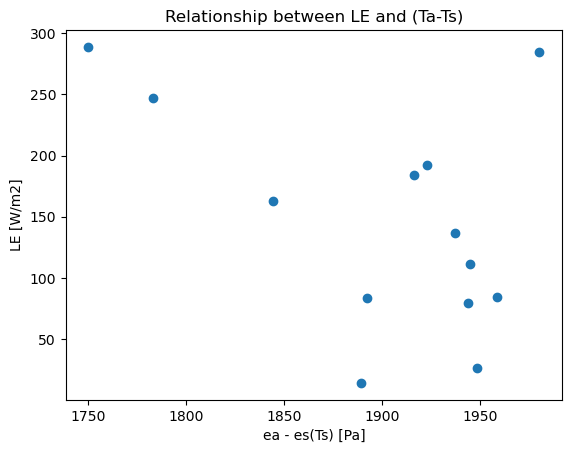

In [158]:
# Data
x = EB_VK_shortgrass['eTs']
y = EB_VK_shortgrass['LE']

# # Linear regression
# coeffs = np.polyfit(x, y, 1)
# fit_line = np.poly1d(coeffs)
# y_pred = fit_line(x)

# R² calculation
r_squared = 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)

# Plot
plt.scatter(x, y, label='Data')
#plt.plot(x, y_pred, color='red', label='Fit Line')
plt.xlabel('ea - es(Ts) [Pa]')
plt.ylabel('LE [W/m2]')
plt.title('Relationship between LE and (Ta-Ts)')

# Add R² to the plot
#plt.text(min(x), min(y), f'$R^2 = {r_squared:.2f}$', fontsize=12)
#plt.legend()
plt.show()


In [289]:
EB_VK_shortgrass['Ts']

datetime
2025-06-17 11:30:00    30.008130
2025-06-17 14:30:00    28.124497
2025-06-17 16:30:00    22.868416
2025-06-17 17:30:00    22.975102
2025-06-17 19:00:00    18.942645
2025-06-17 19:30:00    17.833446
2025-06-18 04:30:00    14.062895
2025-06-18 06:00:00    20.572280
2025-06-18 06:30:00    21.662209
2025-06-18 07:00:00    24.640393
2025-06-18 07:30:00    24.315786
2025-06-18 08:30:00    27.945792
2025-06-18 09:00:00    29.200691
2025-06-18 10:30:00    29.429360
Name: Ts, dtype: float64

In [313]:
merged_df_mobrad

,Index,x,y,lat,lon,DOY,HHMM,SS,Sin,Sout,Lin,Lout,Sn,Ln,Rn,albedo,Ts,TrackTime,TrackDist,TerrainASL,SolarEl,SolarAz,Unnamed: 22,datetime
0,1,0.000000,0.000000,51.981710,5.621690,168,1133,40,895.08,155.95,368.118463,480.379463,739.13,-112.261,626.869,0.174230,30.239358,0.000000,0.000000,-2.0,61.404196,177.688390,NaN,2025-06-17 11:33:40
1,2,0.242108,-0.362193,51.981707,5.621693,168,1133,41,895.08,156.01,368.013849,480.153849,739.07,-112.140,626.930,0.174297,30.203730,0.016667,0.435661,-2.0,61.404303,177.696380,NaN,2025-06-17 11:33:41
2,3,0.484216,-0.724386,51.981703,5.621697,168,1133,42,895.93,156.13,367.902463,479.988463,739.80,-112.086,627.714,0.174266,30.177604,0.033333,0.871321,-2.0,61.404410,177.704370,NaN,2025-06-17 11:33:42
3,4,0.726324,-1.086579,51.981700,5.621700,168,1133,43,896.55,156.18,367.978770,479.860770,740.37,-111.882,628.488,0.174201,30.157428,0.050000,1.306982,-2.0,61.404516,177.712360,NaN,2025-06-17 11:33:43
4,5,0.726324,-1.086579,51.981700,5.621700,168,1133,44,895.81,156.13,367.948003,479.800003,739.68,-111.852,627.828,0.174289,30.147826,0.066667,1.306982,-2.0,61.404618,177.720344,NaN,2025-06-17 11:33:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,695,NaN,NaN,NaN,NaN,169,1042,2,804.01,178.32,376.936836,491.728836,625.69,-114.792,510.898,0.221788,32.015655,11.566667,525.984505,NaN,NaN,NaN,NaN,2025-06-18 10:42:02
695,696,NaN,NaN,NaN,NaN,169,1042,3,807.19,178.42,377.008836,491.788836,628.77,-114.780,513.990,0.221038,32.024964,11.583333,525.984505,NaN,NaN,NaN,NaN,2025-06-18 10:42:03
696,697,NaN,NaN,NaN,NaN,169,1042,4,810.36,178.42,376.977577,491.721577,631.94,-114.744,517.196,0.220174,32.014529,11.600000,525.984505,NaN,NaN,NaN,NaN,2025-06-18 10:42:04
697,698,NaN,NaN,NaN,NaN,169,1042,5,811.58,178.32,377.152149,491.722149,633.26,-114.570,518.690,0.219720,32.014618,11.616667,525.984505,NaN,NaN,NaN,NaN,2025-06-18 10:42:05
